### КАКОЙ КЕЙС РЕШАЕМ?

Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

In [1]:
%%capture

# установка дополнительных библиотек:
!pip install Afinn
!pip install nltk[twitter] 

# инструменты анализа и обработки данных
import pandas as pd
import numpy as np
import re
import geopy.distance
from scipy import stats
from category_encoders import  OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif

# инструменты для лингвистического анализа:
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn
nltk.download('vader_lexicon')

# инструменты для визуализации:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# параметры отображения содержимого на экране:
from IPython.display import display
from IPython.display import Image
from termcolor import colored
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 200)

# загружаем изображения
!ls ../input/projectdata/img_score.png
!ls ../input/projectdata/img.png
!ls ../input/projectdata/wait.png

# инструменты для построения модели:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# фиксируем RANDOM_SEED и версию пакетов, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 42
!pip freeze > requirements.tx

In [2]:
# данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') 
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')

In [3]:
# объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем трейн
df_test['sample'] = 0 # помечаем тест

# в тесте у нас нет значения reviewer_score, заполняем нулями:
df_test['reviewer_score'] = 0 

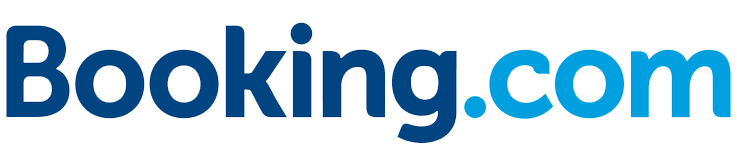

In [4]:
Image('../input/projectdata/img.png')

# 0. Исходные данные:

In [5]:
hotels = df_test.append(df_train, sort=False).reset_index(drop=True)
display(hotels.info())

hotels_isnull = hotels.isnull().sum()
print(
    f'\nСтолбцы с явными пропусками данных:\n{hotels_isnull[hotels_isnull > 0]}'
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

None


Столбцы с явными пропусками данных:
lat    3268
lng    3268
dtype: int64


# 1. Исследование и проектирование признаков (FEATURE ENGINEERING):

## 1.1 ГРУППА ПРИЗНАКОВ ХАРКТЕРИЗУЮЩИХ ОТЕЛЬ
- Название и Адрес отеля ('hotel_address', 'hotel_name')
- Координаты отеля - Географическая широта и долгота отеля ('lat', 'lng')
- Средний балл отеля за последний год ('average_score')
- Общее количество отзывов об отеле ('total_number_of_reviews')
- Общее количество оценок без отзывов ('additional_number_of_scoring')

### <span style="color:blue">НАЗВАНИЕ ОТЕЛЯ ('hotel_name')</span>

In [6]:
# исследуем данные о названии на наличие пропусков и дубликатов:
pivot_n = hotels[['hotel_address', 'hotel_name']].groupby(
    by='hotel_name'
).nunique()

name_rep = pivot_n[pivot_n['hotel_address'] != 1].index.to_list()
mask = hotels['hotel_name'].isin(name_rep)
addresses_rep = hotels[mask][['hotel_name', 'hotel_address']].value_counts()

print(colored('Дублирование Названия отеля:', 'green'))
display(addresses_rep)

# чтобы различать эти отели при анализе - добавим в название город:
hotels['hotel_name'] = hotels.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in name_rep)
    else row['hotel_name'], axis=1)

print(colored('\nПроверим полученные изменения:', 'green'))
mask = hotels['hotel_name'].str.contains(name_rep[0])
display(hotels[mask]['hotel_name'].value_counts())

Дублирование Названия отеля:


hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
dtype: int64


Проверим полученные изменения:


Hotel Regina Barcelona    590
Hotel Regina Vienna       284
Hotel Regina Milan         60
Name: hotel_name, dtype: int64

    Название отеля можно использовать для обучения модели, только если его кодировать. Код названия сам по себе вряд ли может что-то сообщить. Отелей больше тысячи и числовой код скорее запутает модель из-за своей размерности, которая не несет никакой смысловой нагрузки.

    Попробуем сообщить модели хоть какую-то осмысленную информацию. Название - это уникальная характеристика отеля. Отели можно отсортировать, например, по популярности (кол-во отзывов) или по рейтингу (средний бал). Но тогда получится, что наш признак будет дублировать по смыслу или столбец с количеством отзывов, или столбец со средней оценкой.

    Я скорее склоняюсь к идеи удаления этого столбца, но позже, на этапе анализа всех признаков и их влияния на целевую переменную.

    А пока закодируем название, используя обе эти характеристики. Пусть у нас будут только лучшие по отзывам и достаточно популярные отели (как вариант).

In [7]:
# выделим топ лучших по рейтингу, с порогом в 100 отзывов:
hotels_names = hotels.groupby('hotel_name')['average_score'].agg(
    ['mean', 'count'])

mask = (hotels_names['mean'] >= 9.0) & (hotels_names['count'] >= 100)
hotels_top = hotels_names[mask]

print(colored(
    '\nЛучшие по отзывам отели, имеющие минимум 100 отзывов:', 'green'))

display(hotels_top)

hotels['hotel_cat'] = hotels['hotel_name'].apply(
    lambda x: x if x in hotels_top.index else 'other')

# применим порядковое кодирование:
ord_encoder = OrdinalEncoder()
hotels['hotel_cat'] = hotels['hotel_cat'].astype('category')
hotels_bin = ord_encoder.fit_transform(hotels['hotel_cat'])
hotels = pd.concat([hotels, hotels_bin], axis=1)

# удалим исходный столбец
col = hotels.columns.tolist()
col[19] = 'hotel_code'

hotels.set_axis(col, axis=1, inplace=True)
hotels.drop('hotel_cat', axis=1, inplace=True);


Лучшие по отзывам отели, имеющие минимум 100 отзывов:


,mean,count
hotel_name,,
41,9.600,103
Acad mie H tel Saint Germain,9.000,255
Alma Barcelona GL,9.200,179
Amba Hotel Charing Cross,9.300,785
Ambassade Hotel,9.300,551
...,...,...
Waldorf Astoria Amsterdam,9.500,142
art otel Amsterdam,9.000,790
citizenM London Bankside,9.100,1517


### <span style="color:blue">АДРЕС ОТЕЛЯ ('hotel_address')</span>

In [8]:
addresses = pd.Series(hotels['hotel_address'].unique())

print(colored(
    '\nРассмотрим внимательно структуру строк с данными адреса:', 'green'))
display(addresses)


Рассмотрим внимательно структуру строк с данными адреса:


0                                       Via Senigallia 6 20161 Milan Italy
1                    Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands
2                              Mallorca 251 Eixample 08008 Barcelona Spain
3             Piazza Della Repubblica 17 Central Station 20124 Milan Italy
4       Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands
                                       ...                                
1488        45 Park Lane Westminster Borough London W1K 1PN United Kingdom
1489                          6 Avenue Fr miet 16th arr 75016 Paris France
1490                     22 avenue de Villiers 17th arr 75017 Paris France
1491                        17 rue de Richelieu 1st arr 75001 Paris France
1492                          64 Rue Crozatier 12th arr 75012 Paris France
Length: 1493, dtype: object

    Из адреса можно извлечь гораздо больше полезной информации, чем из названия. Страна, город и индекс как характеристика района - могут стать дополнительными признаками!
    
    Идентифицировать район города можно по индексу в строке адреса отеля. Район города способен сильно повлиять на впечатление туриста об отеле. Среди прочих параметров, многие туристы, оставляющие отзыв на Booking.com, часто оценивают месторасположение отеля.

In [9]:
# для определения гео-параметров можно воспользоваться locationtagger, 
# но он работает довольно медленно и с ошибками
# поскольку у нас небольшое количество уникальных стран и городов -
# воспользуемся простой обработкой текста:
countries = addresses.apply(lambda x: x.split()[-1])
countries = countries.apply(
    lambda x: 'United Kingdom' if x == 'Kingdom' else x)

cities = addresses.apply(lambda x: x.split()[-2])
cities = cities.apply(lambda x: 'London' if x == 'United' else x)

addresses = pd.DataFrame(
    {'address': addresses, 'country': countries, 'city': cities})

print(colored(
    '\nВ каждой стране отели представлены только из одного города:', 'green'))
display(addresses.groupby(['country', 'city']).count())

# можно добавить в данные что-то одно - я выберу страну 
#(так потом будет удобнее сопоставлять с национальностью рецензента):
hotels['hotel_country'] = hotels['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

# кодируем информацию о стране:
hotels['hotel_country'] = hotels['hotel_country'].astype('category')
hotels['hotel_country_code'] = hotels['hotel_country'].cat.codes


В каждой стране отели представлены только из одного города:


,,address
country,city,
Austria,Vienna,158
France,Paris,458
Italy,Milan,162
Netherlands,Amsterdam,105
Spain,Barcelona,211
United Kingdom,London,399


In [10]:
def get_postcode(address):
    """Извлечение почтового индекса из строки с адресом."""
    address_list = address.split()
    postcode_place = {
        'Kingdom': -4, 
        'Spain': -3, 
        'France': -3, 
        'Austria': -3, 
        'Netherlands': -4, 
        'Italy': -3
    }
    postcode = str(address_list[postcode_place[address_list[-1]]])
    
    if address_list[-1] == 'Kingdom' and postcode[-1].isalpha():
        return postcode[:-1]
    else:
        return postcode

    
# добавим почтовый индекс отеля как идентификатор района:
hotels['hotel_postcode'] = hotels['hotel_address'].apply(get_postcode)


"""
Замечу, что деление района на тип - центр/исторический центр/остальные -
довольно условное, строгой классификации нет и быть не может. Так как 
городов в данных совсем не много, я разметила типы районов самостоятельно,
используя информацию для туристов из открытых источников.

Просто тут я еще в самом начале работы над проектом; у меня много азарта и
энтузиазма. И я еще не знаю, что преобразования подобного рода значимо
не повлияют на итоговые метрики. А пока ...
"""

# из файла с данными о типе районов - определим категорию района:
districts = pd.read_csv('../input/projectdata/districts.csv')
districts['PostCode'] = districts['PostCode'].apply(lambda x: str(x))
districts = districts.set_index('PostCode')
districts = districts.to_dict()
districts = districts['Type of District']

hotels['district_type'] = hotels['hotel_postcode'].apply(lambda x: districts[x])

# кодируем тип района, сохраняя иерархию туристической привлекательности
# (исторический центр - самые низкие индексы, пригород - наоборот):
def get_district_code(district_type, country_code):
    """Присвоение кода району в зависимости от категории и города."""
    if district_type == 'History Center':
        return country_code
    elif district_type == 'Center':
        return country_code  + 6
    elif district_type == 'Other':
        return country_code + 12
    else:
        return country_code + 18

    
hotels['district_code'] = hotels.apply(
    lambda row: get_district_code(row['district_type'], row['hotel_country_code']
), axis=1)


# категорию району присвоим в зависимости от популярности отелей в нем у туристов
# для этого нормализуем информацию о среднем рейтинге отеля в зависимости от индекса:
pivot_adr = pd.pivot_table(
    hotels, 
    index='hotel_postcode', 
    values='average_score', 
    aggfunc='mean'
)
pivot_adr = pivot_adr.reindex(
    pivot_adr['average_score'].sort_values(ascending=False).index
)

mm_scaler = MinMaxScaler()
x_data = pivot_adr.values
x_scaled = mm_scaler.fit_transform(x_data)
pivot_adr['district_rating'] = x_scaled

hotels['district_rating'] = hotels['hotel_postcode'].apply(
    lambda x: pivot_adr['district_rating'][x]
)

hotels[['hotel_address', 
        'hotel_postcode', 
        'district_rating', 
        'district_type', 
        'hotel_country_code', 
        'district_code']][:10]

,hotel_address,hotel_postcode,district_rating,district_type,hotel_country_code,district_code
0,Via Senigallia 6 20161 Milan Italy,20161,0.502,Other,2,14
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,1043,0.695,Other,3,15
2,Mallorca 251 Eixample 08008 Barcelona Spain,08008,0.782,Center,4,10
3,Piazza Della Repubblica 17 Central Station 20124 Milan Italy,20124,0.697,Center,2,8
4,Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands,1012,0.675,History Center,3,3
5,Coram Street Camden London WC1N 1HT United Kingdom,WC1,0.502,Center,5,11
6,Empire Way Wembley Brent London HA9 8DS United Kingdom,HA9,0.735,Center,5,11
7,1 Shortlands Hammersmith and Fulham London W6 8DR United Kingdom,W6,0.473,Other,5,17
8,35 Rue Caumartin 9th arr 75009 Paris France,75009,0.678,Center,1,7
9,49 Gloucester Place Marble Arch Westminster Borough London W1U 8JE United Kingdom,W1,0.554,Center,5,11


#### <span style="color:green">Визуализируем соотношение средних значений целевой переменной в зависимости от района расположения отеля:</span>

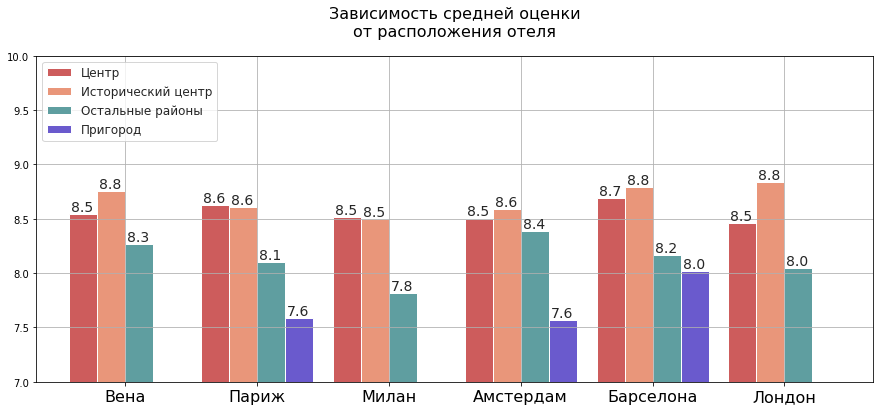

In [11]:
pivot_district_type = hotels[hotels['sample'] == 1].groupby(
    ['hotel_country', 'district_type'])['reviewer_score'].mean().unstack()

cities_rus = ['Вена', 'Париж', 'Милан', 'Амстердам', 'Барселона', 'Лондон']

fig1, ax1 = plt.subplots(figsize=(15, 6))
sns.set_style('whitegrid')
district_type_plot = pivot_district_type.plot(
    ax=ax1, 
    kind='bar', 
    width=0.85, 
    color=['indianred', 'darksalmon', 'cadetblue', 'slateblue'],
    label=cities_rus, 
    rot=0)

ax1.set_title('Зависимость средней оценки\nот расположения отеля', 
              pad = 20, size=16)
ax1.set_xlabel('')
ax1.set_xticklabels(cities_rus, fontsize=16)
ax1.legend(['Центр', 'Исторический центр', 'Остальные районы', 'Пригород'], 
           loc='upper left', fontsize=12)

# для наглядности добавим на диаграмму подписи данных:
for p in district_type_plot.patches:
    district_type_plot.annotate(
        '{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(7, 10);

### <span style="color:blue">ГЕОГРАФИЧЕСКИЕ КООРДИНАТЫ ОТЕЛЯ ('lat', 'lng')</span>

Вообще, координаты сами по себе мало что могут сообщить модели, но можно попробовать извлечь из них какую-то полезную информацию. Например, расстояние до центра города. Из информации о датасете мы помним, что именно в этих столбцах есть пропуски. Сначала удалим пропуски, затем добавим новый признак.

In [12]:
without_coor = len(hotels[hotels.isnull().any(1)]['hotel_name'].value_counts())
print(f'Количество отелей с отсутствующими координатами: {without_coor}')

# вычисляем средние значения координат для каждого района:
pivot_coor = pd.pivot_table(
    hotels, 
    index='hotel_postcode', 
    values=['lat', 'lng'], 
    dropna=True, 
    aggfunc='mean')

hotels['lat'] = hotels.apply(
    lambda row: pivot_coor['lat'][row['hotel_postcode']] \
    if np.isnan(row['lat']) else row['lat'], axis=1)
hotels['lng'] = hotels.apply(
    lambda row: pivot_coor['lng'][row['hotel_postcode']] \
    if np.isnan(row['lng']) else row['lng'], axis=1)

Количество отелей с отсутствующими координатами: 17


In [13]:
# для формирования нового признака нужны координаты центра каждого города 
# (с сайта: https://dateandtime.info/):
centers = pd.DataFrame(
    data = [
        ['United Kingdom', 'London', 51.5085300, -0.1257400],
        ['France', 'Paris', 48.8534100, 2.3488000],
        ['Spain', 'Barcelona', 41.3887900, 2.1589900],
        ['Italy', 'Milan', 45.4642700, 9.1895100],
        ['Austria', 'Vienna', 48.2084900, 16.3720800],
        ['Netherlands', 'Amsterdam', 52.3740300, 4.8896900],
    ],
    columns= ['country', 'city', 'center_lat', 'center_lng']
).set_index('country')


def get_dist_to_center(country, lng, lat):
    """Вычисление дистанции до центра города по координатам."""
    center_lat = centers['center_lat'][country]
    center_lng = centers['center_lng'][country]

    return geopy.distance.geodesic([center_lng, center_lat], [lng, lat]).km


"""
Можно вычислять координаты одной строкой кода, при помощи lambda.
Но geopy.distance.geodesic функция довольно медленная.
Чтобы не обрабатывать 500 тыс. строк - посчитаем эту характеристику 
для каждого отеля и сопоставим полученные результаты.

"""

hotels_unique = hotels[['hotel_name', 'hotel_country', 'lng', 'lat']].drop_duplicates()
hotels_unique['hotel_distance_to_center'] = hotels_unique.apply(
    lambda row: get_dist_to_center(row['hotel_country'], row['lng'], row['lat']), axis=1)

hotels_unique.drop(['hotel_country', 'lng', 'lat'], axis=1, inplace=True)
hotels = hotels.merge(hotels_unique, how='left', on='hotel_name', sort=False)

# теперь столбцы с координатами можно удалить:
hotels.drop(['lng', 'lat'], axis=1, inplace=True)

print(colored('\nПроверим новый признак:', 'green'))
hotels[['hotel_name', 'hotel_distance_to_center']][:15]



Проверим новый признак:


,hotel_name,hotel_distance_to_center
0,Hotel Da Vinci,7.838
1,Urban Lodge Hotel,6.244
2,Alexandra Barcelona A DoubleTree by Hilton,0.564
3,Hotel Principe Di Savoia,1.873
4,Hotel Esther a,0.404
5,Holiday Inn London Bloomsbury,1.736
6,Holiday Inn London Wembley,18.457
7,Novotel London West,10.595
8,Hotel Saint Petersbourg Opera,3.100
9,St George Hotel,3.766


### <span style="color:blue">СРЕДНИЙ БАЛЛ ОТЕЛЯ ('average_score')</span>

Кажется, что это один из самых самодостаточных признаков. Это количественный параметр отеля, в той же размерности и формате, что и целевая переменная. Никаких преобразований с ним выполнять не нужно, а его влияние на показатели целевой переменной оценим в следующем блоке - анализе признаков.

#### <span style="color:blue">ОБЩЕЕ КОЛИЧЕСТВО ОТЗЫВОВ ОБ ОТЕЛЕ ('total_number_of_reviews')</span>
#### <span style="color:blue">ОБЩЕЕ КОЛИЧЕСТВО ОЦЕНОК БЕЗ ОТЗЫВА ('additional_number_of_scoring')</span>

Общее кол-во отзывов - показатель говорит о популярности и/или размере отеля. Но, по моему субъективному ощущению, не сильно влияет на оценку туриста. Он, вместе со вторым показателем, скорее говорит о репрезентативности среднего балла отеля. Думаю, эти признаки не значимы, оставим вопрос об их удалении до этапа отбора признаков.

*P.S. Тут я ошиблась. После построения итоговой модели, признак общего количества отзывов попал в топ важных. Действительно, отели, которые имеют мало отзывов - обычно это новые отели с высокими оценками, которые очень заботятся о своем рейтинге на сайте и проявляют к постояльцам больше внимания. И наконец, в новых отелях просто приятнее находится туристу.*

## 1.2 ГРУППА ПРИЗНАКОВ ХАРКТЕРИЗУЮЩИХ РЕЦЕНЗЕНТА И ЕГО ОПЫТ ПРЕБЫВАНИЯ В ОТЕЛЕ

* Страна рецензента ('reviewer_nationality')
* Теги, которые рецензент дал отелю ('tags')
* Количество отзывов, которые рецензенты дали в прошлом ('total_number_of_reviews_reviewer_has_given')

### <span style="color:blue">СТРАНА РЕЦЕНЗЕНТА ('reviewer_nationality')</span>

    На самом деле, я думаю, что не столько страна, сколько социокультурные особенности представителей определенных регионов, действительно могут сказываться на оценках отелей.
    
    Например, туристы из англо-говорящих стран, почти никогда не сталкиваются с языковым барьером в Европейских отелях. А это немаловажный фактор при заселении, выяснении дополнительной информации и решении возникающих проблем. Отсюда следует, что скорее всего такие туристы будут скорее довольны пребыванием в отеле.
    
    А вот туристы из ближневосточных стран - могут быть недовольны европейскими отелями больше, чем остальные, так как их образ жизни сильнее отличается от европейского.
    
    Добавим дополнительные признаки:

In [14]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
nationality_count = len(hotels["reviewer_nationality"].value_counts())
print(f'Представители {nationality_count} стран являются рецензентами.')

# проанализируем, например, 40 самых распространенных стран, 
# из которых приезжают туристы и выделим общие группы:
print(colored('\nСамые популярные страны:', 'green'))
print(list(hotels['reviewer_nationality'].value_counts(ascending=False)[:40].index))

# выделим основные англоязычные страны:
english_list = ['United Kingdom', 
                'United States of America', 
                'Australia', 
                'Canada', 
                'New Zealand']
hotels['reviewer_en'] = hotels['reviewer_nationality'].apply(
    lambda x: 1 if x in english_list else 0)

# выделим мусульманские страны ближневосточного региона:
muslim_list = ['United Arab Emirates', 
               'Saudi Arabia', 
               'Turkey', 
               'Kuwait', 
               'Qatar', 
               'Oman']
hotels['reviewer_n_est'] = hotels['reviewer_nationality'].apply(
    lambda x: 1 if x in muslim_list else 0)

# добавим признак резидентства туриста по отношению к стране, в которой находится отель:
hotels['reviewer_resident'] = hotels.apply(
    lambda row: 1 if row['reviewer_nationality'] == row['hotel_country'] else 0, axis=1)

# кодируем информацию о стране рецензента:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].astype('category')
hotels['reviewer_nationality_cat'] = hotels['reviewer_nationality'].cat.codes

Представители 227 стран являются рецензентами.

Самые популярные страны:
['United Kingdom', 'United States of America', 'Australia', 'Ireland', 'United Arab Emirates', 'Saudi Arabia', 'Netherlands', 'Switzerland', 'Germany', 'Canada', 'France', 'Israel', 'Italy', 'Belgium', 'Turkey', 'Kuwait', 'Spain', 'Romania', 'Russia', 'South Africa', 'India', 'Greece', 'China', 'Sweden', 'New Zealand', 'Singapore', 'Hong Kong', 'Poland', 'Qatar', 'Austria', 'Egypt', 'Norway', 'Czech Republic', 'Lebanon', 'Hungary', 'Malaysia', 'Thailand', 'Brazil', 'Portugal', 'Finland']


#### <span style="color:green">Визуализируем соотношение средних значений целевой переменной в разрезе полученных признаков:</span>

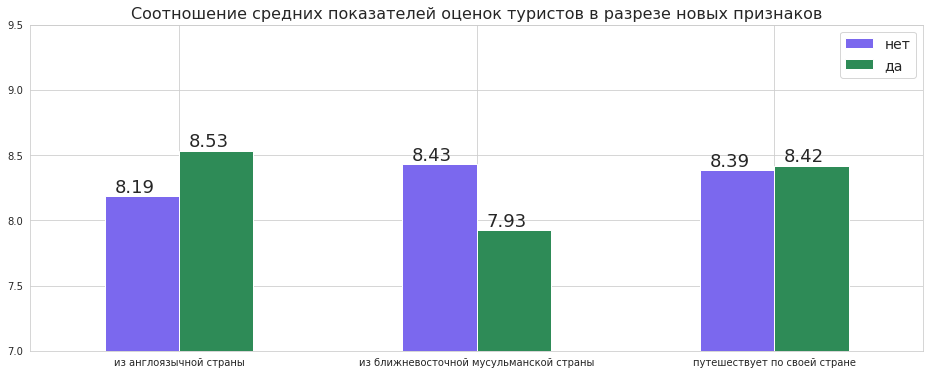

In [15]:
# подготовим данные для диаграммы:
mask = hotels['sample'] == 1
pivot_en = hotels[mask].groupby('reviewer_en')['reviewer_score'].mean()
pivot_n_est = hotels[mask].groupby('reviewer_n_est')['reviewer_score'].mean()
pivot_resident = hotels[mask].groupby('reviewer_resident')['reviewer_score'].mean()

pivot = pd.DataFrame({
    'из англоязычной страны': pivot_en,
    'из ближневосточной мусульманской страны': pivot_n_est,
    'путешествует по своей стране': pivot_resident 
}).T

# строим диаграмму:
fig2, ax2 = plt.subplots(figsize=(16, 6))
pivot_barplot = pivot.plot(
    ax=ax2, 
    kind='bar', 
    color=['mediumslateblue', 'seagreen'], 
    rot=0)
ax2.set_title(
    'Соотношение средних показателей оценок туристов в разрезе новых признаков', size=16)
ax2.legend(['нет', 'да'], loc='upper right', fontsize=14)

# для наглядности добавим на диаграмму подписи данных:
for p in pivot_barplot.patches:
    pivot_barplot.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()),
    ha='center', va='bottom', fontsize=18)

plt.ylim(7, 9.5);

### <span style="color:blue">ТЭГИ('tags')</span>

Визуализируем самые популярные теги набора данных:


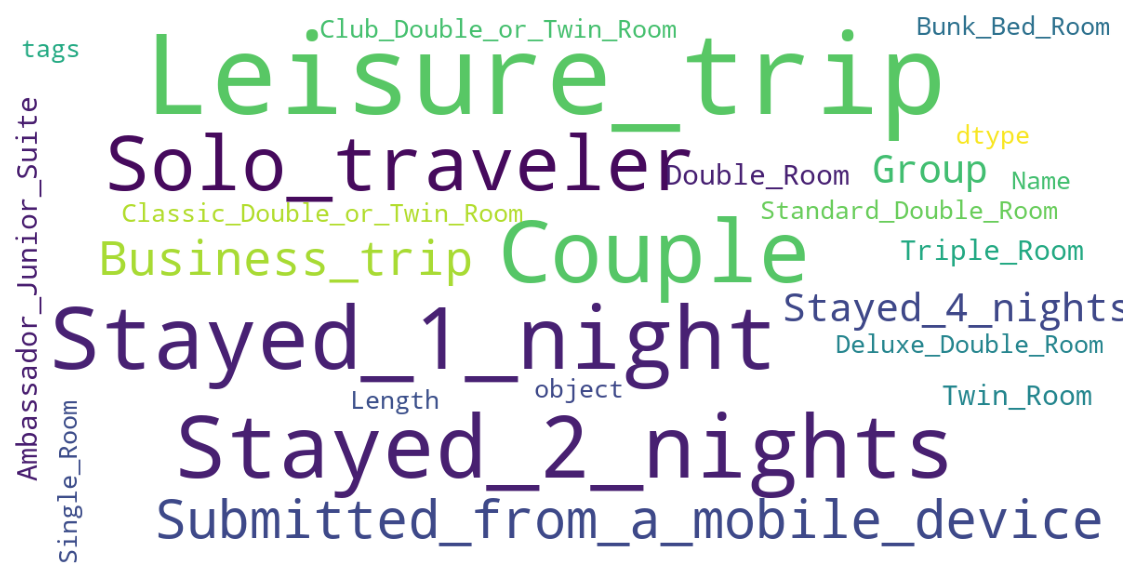

In [16]:
# сохраним в функцию способ визуализации слов, он еще пригодится:
def show_wordcloud(data, background_color, colormap):
    """Рисуем облако слов с заданными параметрами."""
    wordcloud = WordCloud(
        background_color = background_color,
        colormap = colormap,
        max_font_size = 40,
        max_words=100,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

    
print('Визуализируем самые популярные теги набора данных:')

# чтобы увидеть на визуализации именно слитные Тэги, а не отдельные слова, 
# преобразуем строки данных в блоки для каждого тега:
def get_tags_string(tags_data):
    """Соединяем все слова кажого тега нижним подчеркиванием."""
    tags_data = tags_data.replace('[', '').replace(']', '').replace("'", '')
    tags_list = tags_data.split(',')

    tags_string = ''
    for teg in tags_list:
        teg = teg.strip().replace(' ', '_')
        tags_string = tags_string + teg + ' '

    return tags_string

# рисуем диаграмму:
cloud = hotels['tags'].apply(get_tags_string)
show_wordcloud(cloud, 'white', 'viridis')

Рассмотрим и проанализируем типы тегов:

In [17]:
hotels['len_tags'] = hotels['tags'].apply(lambda x: len(x.split(',')))

print(f'Максимальное количество тегов в 1 строке данных: {hotels["len_tags"].max()}/n')

print('Примеры:')
print(hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].iloc[0])
print(hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].iloc[1])

Максимальное количество тегов в 1 строке данных: 6/n
Примеры:
[' With a pet ', ' Leisure trip ', ' Family with young children ', ' Double or Twin Room 1 2 Adults ', ' Stayed 7 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Couple ', ' Deluxe Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']


**Можно выделить 6 типов тегов:**
* путешествие с домашними животными 
* путешествие по работе / отдых
* путешествие в каком составе (один, пара, компания друзей, семья с маленькими / взрослыми детьми, группа)
* категория номера
* длительность поездки
* доступ осуществляется с мобильного устройства



In [18]:
"""
Принцип выделения полезных свойств следующий - мы знаем, что максимальное 
количество тегов 6 и знаем их возможные типы. Все они, кроме типа комнаты, 
укладываются в стандартный шаблон. Будем искать в каждой строке один из пяти
известных шаблонов тега и удалать из строки после обработки. Если останется 
какой-то еще тег - он и будет типом номера.
"""

# создаем новые признаки:
def get_tags(tags_string):
    """Выделение 6 типов тегов по шаблонам."""
    tags_string = tags_string.replace('[', '').replace(']', '')
    tags_string = tags_string.replace("' ", '').replace(" '", '')
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list))

    # сразу кодируем тип путешественника:
    reviewer_types = {'Solo traveler': 1,
                      'Couple': 2,
                      'Travelers with friends': 3,
                      'Family with young children': 4,
                      'Family with older children': 5,
                      'Group': 6}

    # формируем новые параметры:
    tag_from_mobile = 0
    tag_with_pet = 0
    tag_leisure_trip = 1 #  по умолчанию не считаем поездку командировкой
    tag_reviewer_type = 0
    tag_count_nights = 0
    tag_room_type = ''
    
    # распределяем те теги, которые есть в исходной строке:
    for teg in list(tags_list):
        if teg == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(teg)

        if teg == 'With a pet':
            tag_with_pet = 1
            tags_list.remove(teg)

        if teg == 'Business trip':
            tag_leisure_trip = 0
            tags_list.remove(teg)

        if teg == 'Leisure trip':
            tags_list.remove(teg)

        if teg in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[teg]
            tags_list.remove(teg)

        if re.fullmatch(r'Stayed\s\d+\snight\w?', teg):
            tag_count_nights = [float(s) for s in re.findall(r'-?\d+\.?\d*', teg)][0]           
            tags_list.remove(teg)
            
        if len(tags_list) > 0:
            tag_room_type = tags_list[0]

    return tag_from_mobile, tag_with_pet, tag_leisure_trip, \
        tag_reviewer_type, tag_count_nights, tag_room_type


# формируем новые признаки:
hotels[['tag_from_mobile',
        'tag_with_pet',
        'tag_leisure_trip',
        'tag_reviewer_type',
        'tag_count_nights',
        'tag_room_type']
] = pd.DataFrame(hotels['tags'].apply(get_tags).to_list(), index=hotels.index)

print(colored('\nКоличество уникальных значений в новых признаках:', 'green'))
hotels[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
        'tag_reviewer_type', 'tag_count_nights', 'tag_room_type']].nunique()


Количество уникальных значений в новых признаках:


tag_from_mobile         2
tag_with_pet            2
tag_leisure_trip        2
tag_reviewer_type       6
tag_count_nights       32
tag_room_type        2394
dtype: int64

Рассмотрим внимательно категории номеров. Возможно получится выделить их в группы. Кажется, что отзывы о пребывании туристов, которые останавливаются в большом клубном номере с видом и в маленьком экономе могут сильно отличаться.

    Из типа номера дополнительно выделим признак - номер с видом (думаю, что средний балл отзывов гостей таких номеров должен быть выше обычных).

In [19]:
# оптимизируем тип данных (для последующей диаграммы):
hotels['tag_count_nights'] = hotels['tag_count_nights'].astype('int8')

# добавим признак номера с видом:
hotels['tag_view_room'] = hotels['tag_room_type'].apply(
    lambda x: 1 if ('View' in x) | ('Panoramic' in x) else 0)


# сформируем список основных категорий отельных номеров 
# и присвоим соответствующее значение каждой группе:
def get_room_type(tag):
    """Классификация типа номера."""
    room_types = ['without Window', 'Guestroom', 'Classic', 'Single', 
                  'Standard', 'Superior', 'Comfort', 'Club', 'Suite', 
                  'Deluxe', 'King', 'Premier']

    for rt in room_types:
        if rt in tag:
            return rt

    if 'Double' in tag or 'Twin' in tag:
        return 'Double'

    return 'Other'


# группируем данные с типом номера:
hotels['room_type'] = hotels['tag_room_type'].apply(get_room_type)

# кодируем новые признаки
encoder_t = OneHotEncoder(cols=['tag_reviewer_type'], use_cat_names=True)
tag_type_bin = encoder_t.fit_transform(hotels['tag_reviewer_type'])
hotels = pd.concat([hotels, tag_type_bin], axis=1)

encoder_r = OneHotEncoder(cols=['room_type'], use_cat_names=True)
tag_rooms_bin = encoder_r.fit_transform(hotels['room_type'])
hotels = pd.concat([hotels, tag_rooms_bin], axis=1)

#### <span style="color:green">Визуализируем таблицу распределения целевой переменной в разрезе количества проведенных в отеле дней, а также соотношение ее средних значений в зависимости от категории номера:</span>

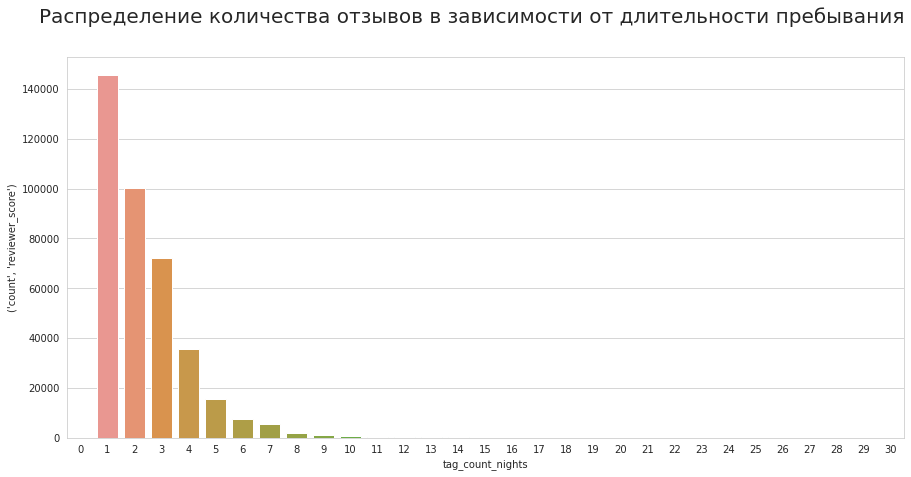

In [20]:
pivot_nights = pd.pivot_table(
    hotels[hotels['sample'] == 1], 
    index='tag_count_nights', 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])
fig3, ax3 = plt.subplots(figsize=(15, 7))
plt.suptitle(
    'Распределение количества отзывов в зависимости от длительности пребывания', size=20)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')]);

***Наибольшие группы - это туристы, совершавшие короткие поездки длительностью 1-3 ночи. Логично, для городских отелей. С возрастанием длительности пребывания - количество отзывов постепенно снижается, а после показателя в 14 ночей (стандартная длина отпуска) - их количество падает резко.***

Странно, что у некоторых данных отсутствует информация о длительности пребывания в отеле. Вообще сайт тщательно проверяет отзывы на реальность.
Возможно это поездки, задним числом аннулированные отелем с возвратом денег туристу, например, а отзыв о пребывании уже был опубликован.
Если обратить внимание на отзывы - то это в основном негативные отзывы. Не будем заменять эти значения средними показателями.

***А теперь посмотрим, есть ли зависимость средних оценок от категорий номера:***

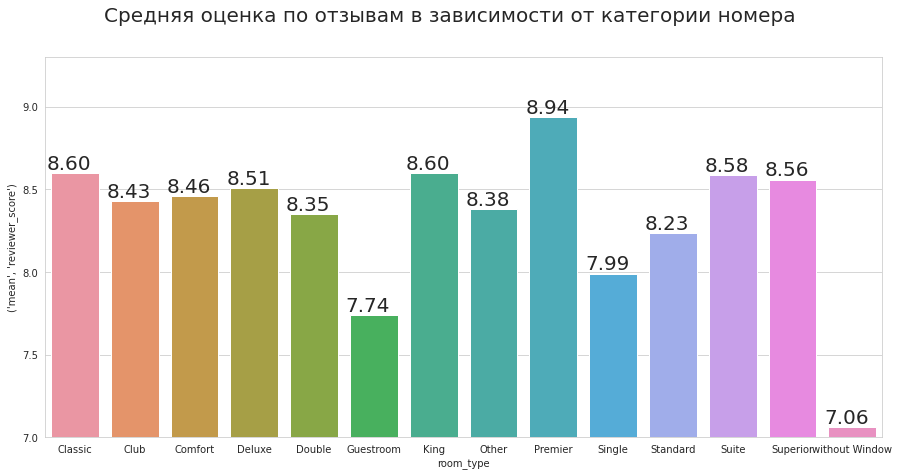

In [21]:
# визуализируем различия в оценках туристов, в зависимости от типа номера:
pivot_types = pd.pivot_table(hotels[hotels['sample'] == 1], 
                             index='room_type', 
                             values='reviewer_score', 
                             aggfunc=['count', 'mean'])

fig4, ax4 = plt.subplots(figsize=(15, 7))
plt.suptitle('Средняя оценка по отзывам в зависимости от категории номера', size=20)
bar_types = sns.barplot(
    x=pivot_types.index, 
    y=pivot_types[('mean', 'reviewer_score')])

for p in bar_types.patches:
    bar_types.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
    ha='center', va='bottom', fontsize=20)

plt.ylim(7, 9.3);

Да, без окна действительно, наверно не сладко :D

In [22]:
# удалим вспомогательные столбцы:
hotels.drop(['tag_reviewer_type', 'room_type', 'tag_room_type', 'len_tags'], 
            axis=1, inplace=True)

### <span style="color:blue">ОБЩЕЕ КОЛИЧЕСТВО ОТЗЫВОВ РЕЦЕНЗЕНТА ('total_number_of_reviews_reviewer_has_given')</span>

Кажется, что такой параметр, как количество отзывов у рецензента - вообще не влияет на оценку отелю. Но возможно, конечно, что "умудренные опытом" путешественники более требовательны и строги к объекту размещения. Или напротив, люди, которые много путешествуют - лучше знают чего хотят и имеют больше опыта в выборе объекта размещения. А значит, реже разочаровываются... Эти гипотезы нуждаются в проверке. Оставим решение вопроса об удалении на этап анализа и отбора признаков.

In [23]:
print(colored(
    '\nПосмотрим на количество отзывов рецензентов по группам активности:', 'green'))
print(hotels['total_number_of_reviews_reviewer_has_given'].groupby(
    pd.cut(hotels['total_number_of_reviews_reviewer_has_given'], 
           np.arange(0, 360, 25))).agg('count'))

# логарифмируем значение признака, чтобы оставить только информацию 
# о степени (порядке) активности рецензента:
hotels['total_number_of_reviews_reviewer_has_given'] = \
    hotels['total_number_of_reviews_reviewer_has_given'].apply(lambda x: np.log(x+1))


Посмотрим на количество отзывов рецензентов по группам активности:
total_number_of_reviews_reviewer_has_given
(0, 25]       488425
(25, 50]       21640
(50, 75]        3914
(75, 100]       1149
(100, 125]       294
(125, 150]       144
(150, 175]       119
(175, 200]        21
(200, 225]        12
(225, 250]         8
(250, 275]         2
(275, 300]         4
(300, 325]         4
(325, 350]         1
Name: total_number_of_reviews_reviewer_has_given, dtype: int64


## 1.3 ХАРКЕТИРСТИКИ ВРЕМЕНИ - ДАТЫ И ПЕРИОДЫ
* Дата размещения отзыва ('review_date')
* Разница между датой отзыва и датой выгрузки данных ('days_since_review')

### <span style="color:blue">ДАТА РАЗМЕЩЕНИЯ ОТЗЫВА ('review_date')</span>

У меня есть гипотеза, что на оценку туриста, параметр безусловно субъективный, часто влияет не только опыт пребывания в отеле, но и атмосфера путешествия в целом.

- Не секрет, что лучшим временем для путешествия в крупные европейские города, многие считают период зимних новогодних и рождественских праздников. Улицы европейских мегаполисов превращаются в большие рождественские ярмарки, а в отелях царит непринужденная праздничная атмосфера. Кажется, это сильно должно влиять на общую оценку отелю.
- Весна, также прекрасное время для посещения европейских городов. Уже довольно тепло для прогулок, но нет толп назойливых туристов.
- Лето, конечно, спорный период. Это пора отпусков и даже городские отели часто переполнены. Но долгожданное посещение Парижа или Милана может подпортить жара, например, проблемы с кондиционером, или очереди на завтраке. Персонал часто не справляется с большим потоком посетителей, отсюда, предполагаю что оценки посещения отеля летом будут одними из самых низких.
- Ну и осень. Осенью в Европейских отелях тоже не сладко :D. Начинаются холодные промозглые денечки, в номерах часто холодно и сыро. После летнего туристического сезона именно осенью многие отели устраивают ремонтные работы к рождественским каникулам, что может вызвать дополнительный дискомфорт постояльцев.

Мне кажется, что логичнее всего выделить в отдельные признаки - месяц, неделю и время года посещения отеля.

*PS. В последствии я отказалась от идеи сформировать время года в отдельный признак. И порядковое и категориальное кодирование сезона года ухудшало итоговый MAPE.*

In [24]:
# преобразуем данные в столбце в формат даты/времени:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# формируем новые признаки:
hotels['review_week'] = hotels['review_date'].apply(
    lambda x: x.isocalendar()[1])
hotels['review_month'] = hotels['review_date'].dt.month

#### <span style="color:green">Визуализируем влияние месяца посещения отеля на средние настроения туристов:</span>

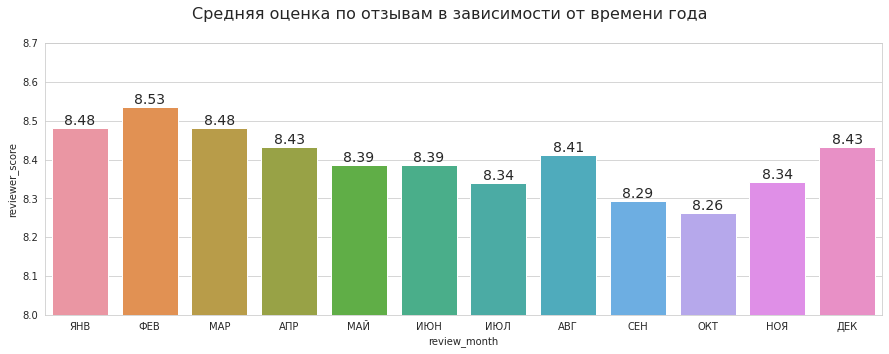

In [25]:
mask = hotels['sample'] == 1
pivot_month = hotels[mask][['review_month', 'reviewer_score']].groupby(
    'review_month').mean()
fig5, ax5 = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от времени года', size=16)
bar_month = sns.barplot(
    x=pivot_month.index, 
    y=pivot_month['reviewer_score'])
ax5.set_xticklabels([
    'ЯНВ', 'ФЕВ', 'МАР', 'АПР', 'MAЙ', 'ИЮН', 
    'ИЮЛ', 'АВГ', 'СЕН', 'ОКТ', 'НОЯ', 'ДЕК'])

for p in bar_month.patches:
    bar_month.annotate(
        '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(8, 8.7);

### <span style="color:blue">ВОЗРАСТ ОТЗЫВА В ДНЯХ ПРИ ВЫГРУЗКЕ ДАННЫХ ('days_since_review')</span>

Тут даже предположить не могу - как может возраст отзыва влиять на оценку. Можно выдвинуть гипотезу, разве что, что “раньше люди были добрее”. Но так как период давности в наших данных ограничивается всего лишь 2 годами, даже она, по моему, не состоятельна :D
Информация о возможной сезонности уже получена из даты, а этот признак удалим, со спокойной совестью, не откладывая до этапа отбора признаков.

In [26]:
hotels.drop('days_since_review', axis = 1, inplace=True)

## 1.4 ОТЗЫВЫ
- Отрицательный отзыв, который рецензент дал отелю ('negative_review')
- Положительный отзыв, который рецензент дал отелю ('positive_review')
- Общее количество слов в отрицательном отзыве ('review_total_negative_word_counts')
- Общее количество слов в положительном отзыве ('review_total_positive_word_counts')

Структура отзыва об отеле на сайте “Booking.com” устроена таким образом, что содержит в себе две части: Отрицательный отзыв и Положительный отзыв. 

После выставления оценок по категориям рецензенту предлагается ответить на два вопроса:
- Что вам не понравилось в объекте размещения?
- Что вам понравилось в объекте размещения?

Таким образом получается две части одного по сути отзыва.

### <span style="color:blue">КОЛИЧЕСТВО СЛОВ В ОТЗЫВЕ</span>

Если посчитать фактическое количество слов в строке с отзывом - то оно будет отличаться от данных на 1-2 пункта.
А количество слов равное 0 - соответствует меткам 'No Positive' / 'No Negative', то есть фактическому отсутствию отзыва.
Не считаю этот факт критичным и оставляю данные в этом аспекте без преобразований.

***Эти признаки уже напрямую дают нам информацию о том, удовлетворен ли турист пребыванием в отеле. В большинстве случаев, если все было прекрасно, на вопрос: Что вам не понравилось? - вы не ответите ничего или обойдетесь стандартной фразой типа "Все понравилось" или "Все было прекрасно!". Если же есть на что пожаловаться - эта часть отзыва будет значительно длиннее. С положительной частью - то же самое. Проверим эту гипотезу:***

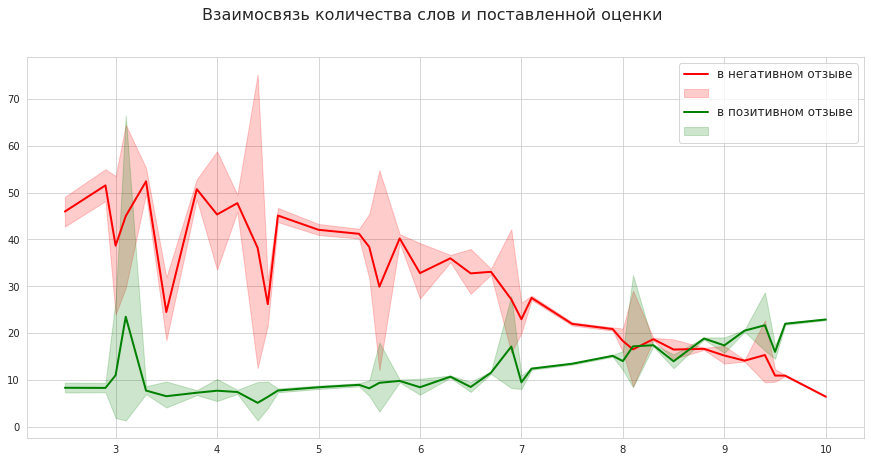

In [27]:
fig6, ax6 = plt.subplots(figsize=(15, 7))
plt.suptitle('Взаимосвязь количества слов и поставленной оценки', size=16)
line_count_neg = sns.lineplot(
    data=hotels[mask],
    x='reviewer_score',
    y='review_total_negative_word_counts',
    color='red', linewidth=2
)
line_count_pos = sns.lineplot(
    data=hotels[mask],
    x='reviewer_score',
    y='review_total_positive_word_counts',
    color='green', linewidth=2
)
ax6.set_xlabel('')
ax6.set_ylabel('')
ax6.legend(['в негативном отзыве', '', 'в позитивном отзыве', ''], 
           loc='upper right', fontsize=12);

### <span style="color:red">Лирическое отступление про систему оценкок на Booking.com</span>

На самом деле, связь гораздо сильнее, чем может показаться. Это связано со спецификой выставления оценок на сайте Booking.com.
До 2019, кажется года, система оценок там была следующая:

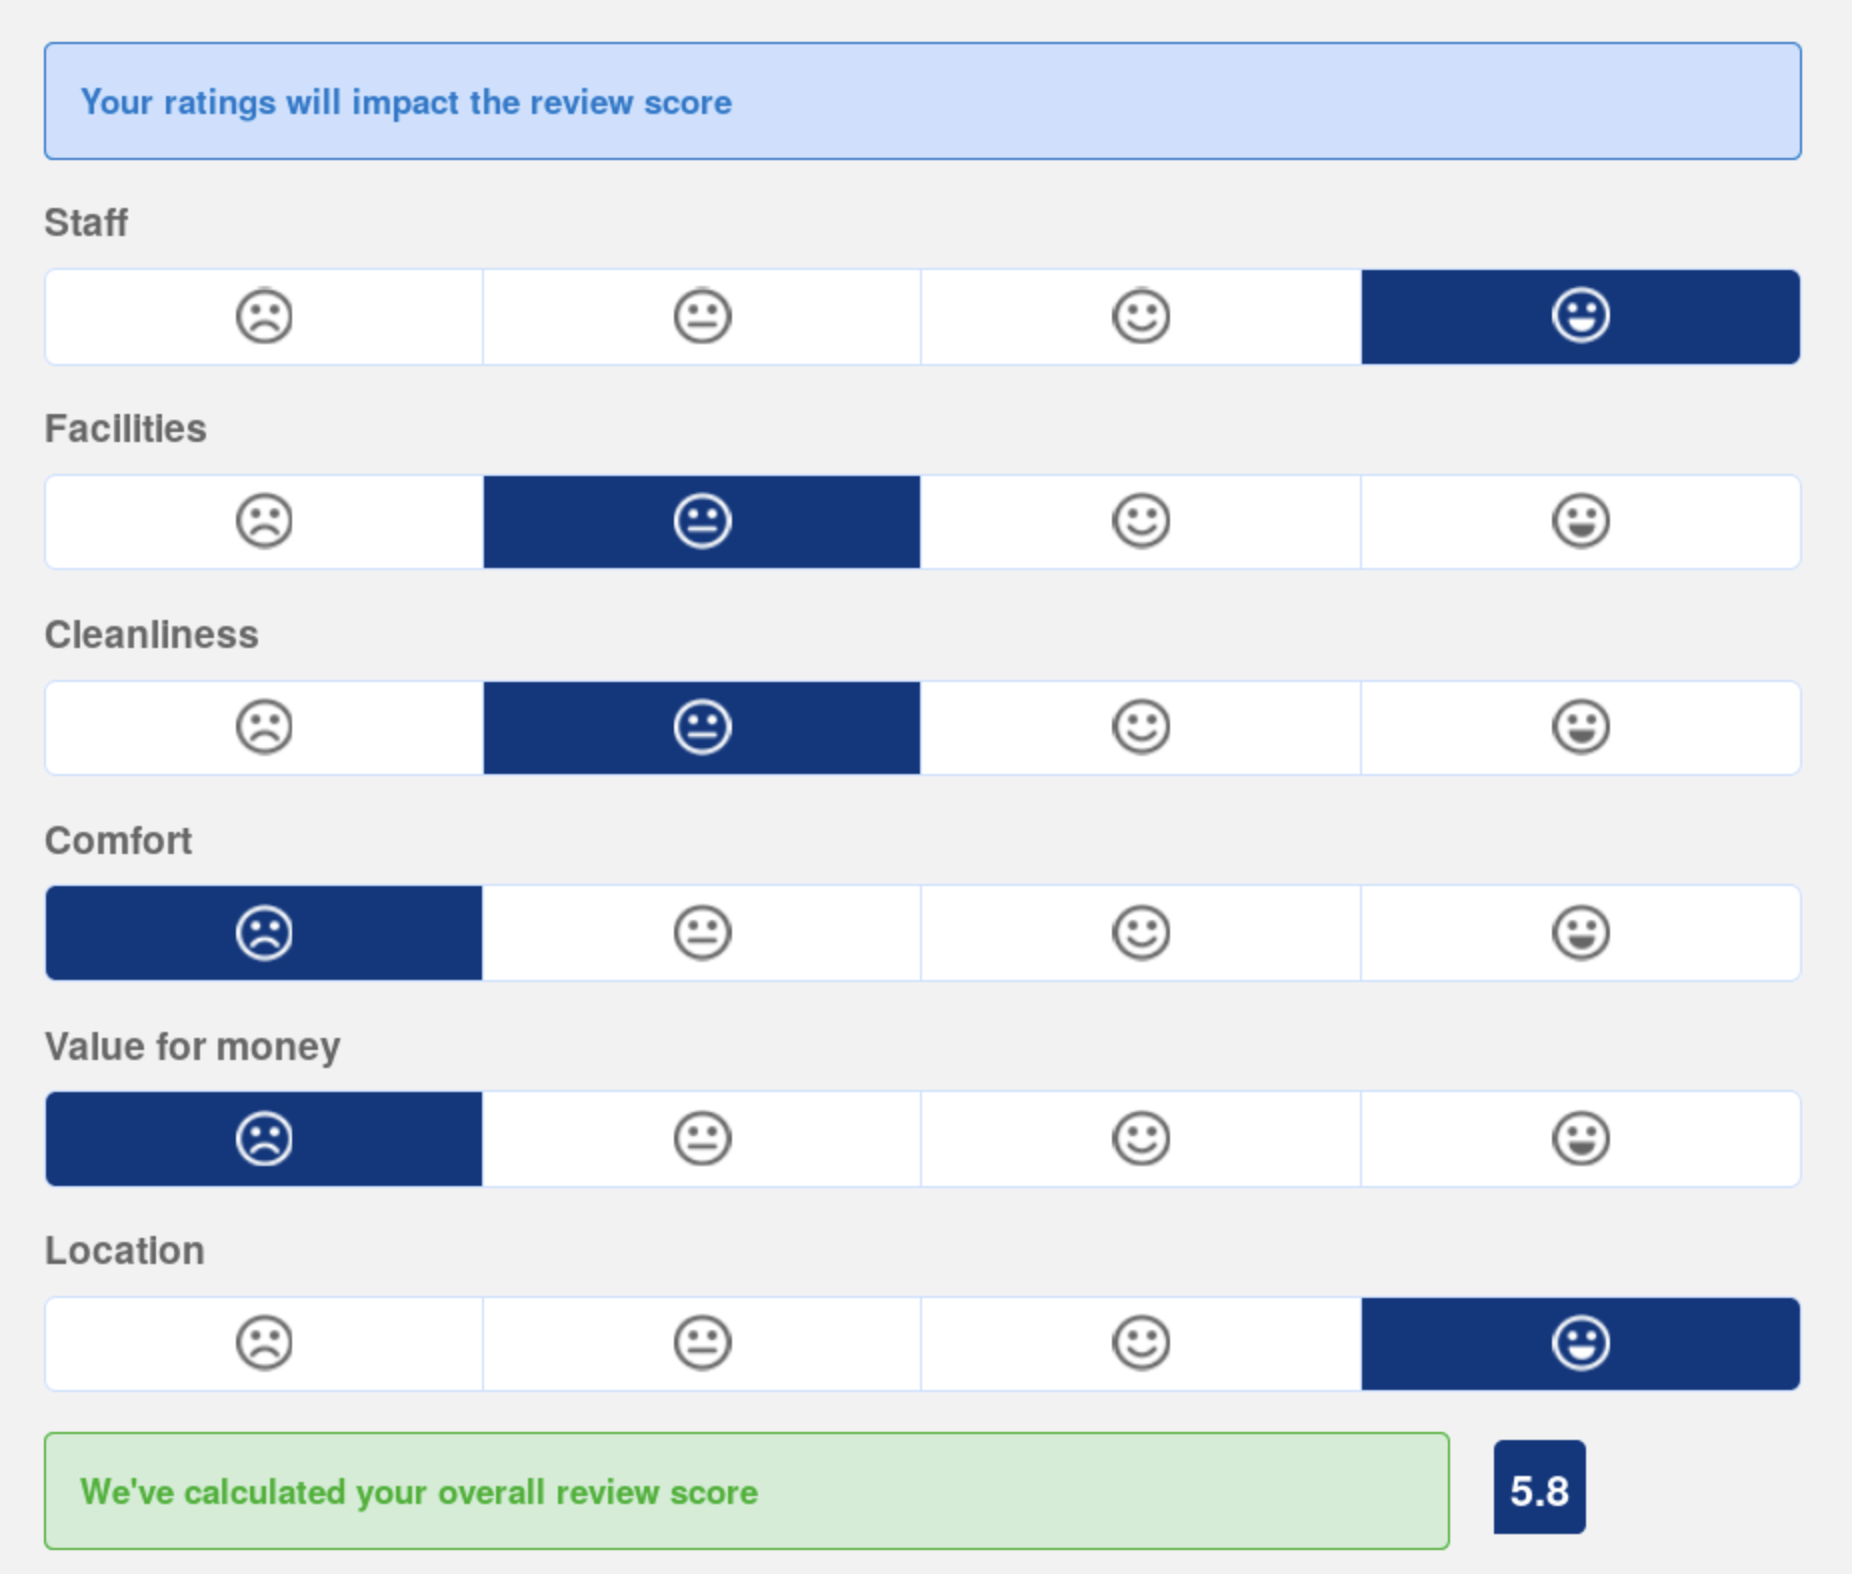

In [28]:
Image(filename='../input/projectdata/img_score.png', width=600)

Рецензент оценивает 6 категорий в 4 степенях. Каждая категория - 10 баллов суммарно, за каждый шаг + 2,5 балла к сумме по категории, а итоговая оценка - среднее арифметическое с округлением до десятых.

Если визуализировать распределение всех оценок - мы увидим основное движение как раз по этим 19 значениям:

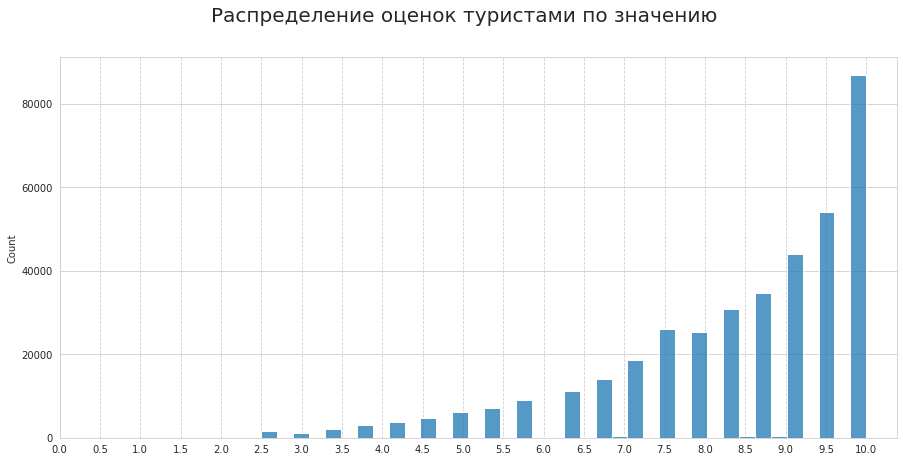

In [29]:
fig1, ax1 = plt.subplots(figsize=(15, 7))
plt.suptitle('Распределение оценок туристами по значению', size=20)
sns.histplot(
    ax=ax1, 
    data=hotels[mask]['reviewer_score'], 
    bins=len(hotels['reviewer_score'].value_counts())
).xaxis.grid(linestyle='--')
ax1.set_xticks(np.arange(0, 10.5, 0.5))
ax1.set_xlabel('');

In [30]:
# разделим список всех оценок с их количествами на две части
# 1) те которые укладываются в систему оценки
# 2) остальные
scores_list_1 = hotels[mask]['reviewer_score'].value_counts().iloc[:19]
scores_list_2 = hotels[mask]['reviewer_score'].value_counts().iloc[19:]

print(colored('\nОценки, укладывающиеся в систему оценивания Booking.com:', 'green'))
display(scores_list_1)

print(colored('\nОценки, не укладывающиеся в систему оценивания Booking.com:', 'green'))
display(scores_list_2)


Оценки, укладывающиеся в систему оценивания Booking.com:


10.000    86803
9.600     53502
9.200     44053
8.800     34795
8.300     30903
7.500     26164
7.900     24901
7.100     18529
6.700     14117
6.300     11244
5.800      8962
5.400      7082
5.000      6278
4.600      4660
4.200      3827
3.800      3017
3.300      2063
2.500      1632
2.900      1211
Name: reviewer_score, dtype: int64


Оценки, не укладывающиеся в систему оценивания Booking.com:


9.500    523
9.000    483
8.000    388
8.500    379
7.000    293
6.500    274
6.000    184
5.500    161
4.500     97
4.000     66
3.500     61
9.400     47
8.100     28
3.000     25
6.900     23
5.600     13
4.400      9
3.100      6
Name: reviewer_score, dtype: int64

 Если посмотреть на динамику самых популярных оценок - то это те самые 10, 9.6, 9.2 и так далее. Вполне себе нормальное одностороннее (или экпоненциальное) распределение.

А вот откуда взялись остальные оценки, с шагом по 0.5 - не очень понятно. Суммарное их количество - меньше процента от общего числа. Может это, например, результаты тестирования альтернативной системы оценивания, или просто поврежденные данные, или еще что-то.

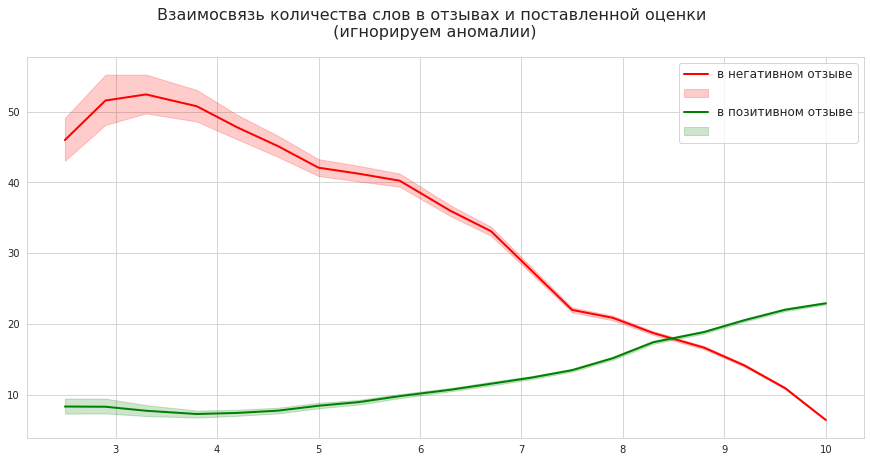

In [31]:
# а теперь визуализируем связь количества слов в отзыве и уровня оценки 
# без учета этих 1% аномальных значений:
hotels_filtered = hotels[
    mask & (hotels['reviewer_score'].isin(scores_list_1.index.to_list()))]

fig7, ax7 = plt.subplots(figsize=(15, 7))
plt.suptitle(
    'Взаимосвязь количества слов в отзывах и поставленной оценки\n (игнорируем аномалии)', 
    size=16)
line_count_neg = sns.lineplot(
    data=hotels_filtered,
    x='reviewer_score',
    y='review_total_negative_word_counts',
    color='red', linewidth=2
)
line_count_pos = sns.lineplot(
    data=hotels_filtered,
    x='reviewer_score',
    y='review_total_positive_word_counts',
    color='green', linewidth=2
)
ax7.set_xlabel('')
ax7.set_ylabel('')
ax7.legend(['в негативном отзыве', '', 'в позитивном отзыве', ''], 
           loc='upper right', 
           fontsize=12);

### <span style="color:red">конец лирического отступления.</span>

#### Посмотрим на распределения этих признаков:

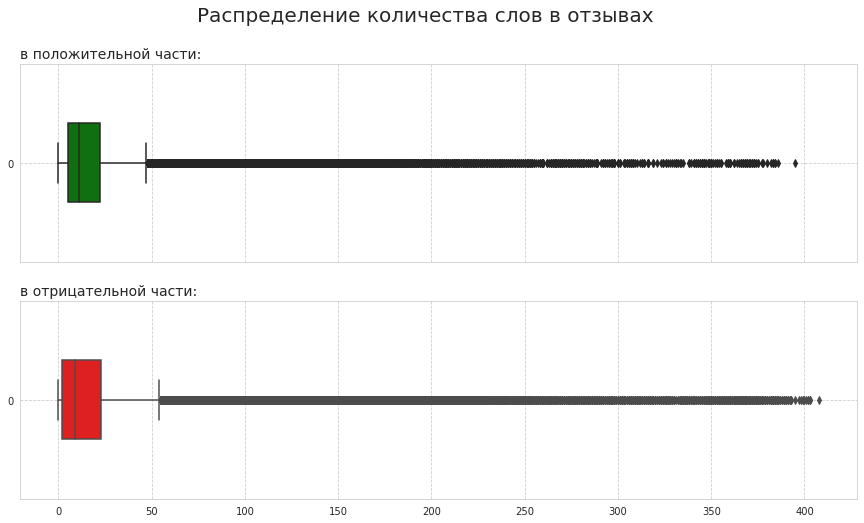

In [32]:
# формируем размеры диаграмм:
fig10, ax10 = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(15, 8))
plt.suptitle('Распределение количества слов в отзывах', size=20)

sns.boxplot(
    ax=ax10[0], 
    data=hotels['review_total_positive_word_counts'], 
    color='green', 
    width=0.4, 
    orient='h'
).grid(linestyle='--')

sns.boxplot(
    ax=ax10[1], 
    data=hotels['review_total_negative_word_counts'], 
    color='red', 
    width=0.4, 
    orient='h'
).grid(linestyle='--')
ax10[0].set_title('в положительной части:', ha='left', x=.0, fontsize=14)
ax10[1].set_title('в отрицательной части:', ha='left', x=.0, fontsize=14);

Распределения односторонние (похожие на распределения целевого признака), большой разброс значений за пределами границы третьего квартиля - это конечно не аномалии, а специфика этих данных. Взаимодополняющее влияние количества слов в двух частях отзыва - это одна из самых сильных зависимостей в этом датасете.

Сначала у меня были идеи как-то обработать количество слов, ограничить по методу Тьюки или, например, логарифмировать данные. Но не одно их этих преобразований не давало значимого улучшения итоговых метрик, и я от них отказалась. Судя по всему, масштаб каждого вида данных в отдельности - не сильно влияет на предложенный алгоритм построения модели (Random Forest).

Приводить данные к единой размерности есть смысл только, если нужно сделать сравнение их между собой.

Целевая переменная демонстрирует зависимость от обеих величин. Соединим оба эффекта в один, добавив разницу количества слов в позитивной и негативной частях отзыва (предварительно нормализуем обе шкалы):

In [33]:
mm_scaler = MinMaxScaler()

hotels['review_total_positive_word_counts_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_positive_word_counts'])),
    columns=['review_total_positive_word_counts'])

hotels['review_total_negative_word_counts_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_negative_word_counts'])),
    columns=['review_total_negative_word_counts'])

# соединим эти показатели в один, отрицательные слова - с отрицательным коэффициентом:
hotels['review_total_word_counts_diff_norm'] = \
    hotels['review_total_positive_word_counts_norm'] - \
    hotels['review_total_negative_word_counts_norm']

# а также добавим флаг - преобладают ли позитивные слова над негативными 
# в размерностях соответствующих диапазонов:
hotels['positive_words_more'] = hotels['review_total_word_counts_diff_norm'].apply(
    lambda x: 1 if x >= 0 else 0)

hotels.drop(
    ['review_total_positive_word_counts_norm', 'review_total_negative_word_counts_norm'], 
    axis=1, inplace=True)

Также добавим долю одной из частей (второй показатель будет обратно пропорциональным, очевидно - не значимым):

In [34]:
hotels['review_total_word_counts'] = \
    hotels['review_total_positive_word_counts'] + \
    hotels['review_total_negative_word_counts']

# если общее количество слов равно 0, то считаем обе части равнозначными (по 0.5):
hotels['review_positive_word_proportion'] = hotels.apply(
    lambda row: 0.5 if row['review_total_word_counts'] == 0 \
            else row['review_total_positive_word_counts'] / row['review_total_word_counts'],
axis=1)

# удаляем вспомогательный столбец:
hotels.drop('review_total_word_counts', axis = 1, inplace=True)

### <span style="color:blue">НЕПОСРЕДСТВЕННО ОТЗЫВ (‘negative_review’, ‘positive_review’)</span>

А теперь - самое интересное:D 
Огромное количество информации для лучшего предсказания итоговой оценки содержится именно в этих столбцах! 

Но для того чтобы параметрически оценить эти данны - нужен будет лингвистический анализ текста. Я попробую два подхода:
*     VADER (Valence Aware Dictionary and sEntiment Reasoner) — это основанный на лексике и правилах инструмент анализа настроений, специально настроенный на чувства, выраженные в социальных сетях.

    [Библиотека на GitHub тут](https://github.com/cjhutto/vaderSentiment)

* TextBlob — это библиотека Python (2 и 3) для обработки текстовых данных. Он предоставляет простой API для погружения в общие задачи обработки естественного языка (NLP), такие как тегирование частей речи, извлечение именной фразы, анализ тональности, классификация, перевод и многое другое. 

    [Ссылка на сайт библиотеки тут ](https://textblob.readthedocs.io/en/dev/)

* Собственные идеи классификации текста

Начнем это увлекательнейшее исследование с красивой визуализации самых популярных слов (она стоит следующих 30 строчек кода):

In [35]:
# визуализируем основные слова положительных и отрицательных частей отзывов
# загружаем словарь для лемматизации
nlp = spacy.load('en_core_web_sm')
stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()


def clean_text(text):
    """Очистка от стоп-слов и лемматизация текста"""
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word for word in text if word not in stop]
    text = " ".join(text)
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


def get_words_string(words_data):
    """Соединение очищенных слов в единую строку"""
    words_string = ''
    for word in words_data:
        words_string = words_string + word + ' '
    return words_string


def draw_cloud(text_column, background, color_map):
    """Визуализация словарных наборов"""
    hotels['temp'] = hotels[text_column].apply(
        lambda x: x.replace('No Negative', '').replace('No Positive', ''))
    hotels.temp = hotels[text_column].apply(clean_text)
    cloud_data = hotels.temp.apply(get_words_string)
    # воспользуемся функцией для визуализации тегов:
    show_wordcloud(cloud_data, background, color_map)


ОБЛАКО СЛОВ ПОЗИТИВНЫХ ОТЗЫВОВ:



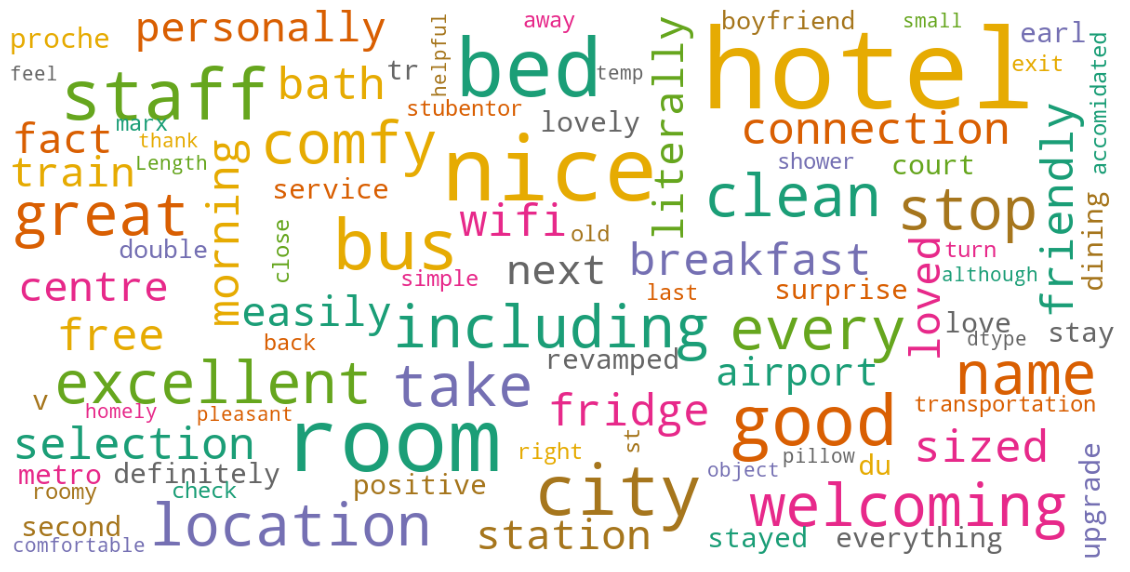

In [36]:
print('\nОБЛАКО СЛОВ ПОЗИТИВНЫХ ОТЗЫВОВ:\n')
draw_cloud('positive_review', 'white', 'Dark2');


ОБЛАКО СЛОВ НЕГАТИВНЫХ ОТЗЫВОВ:



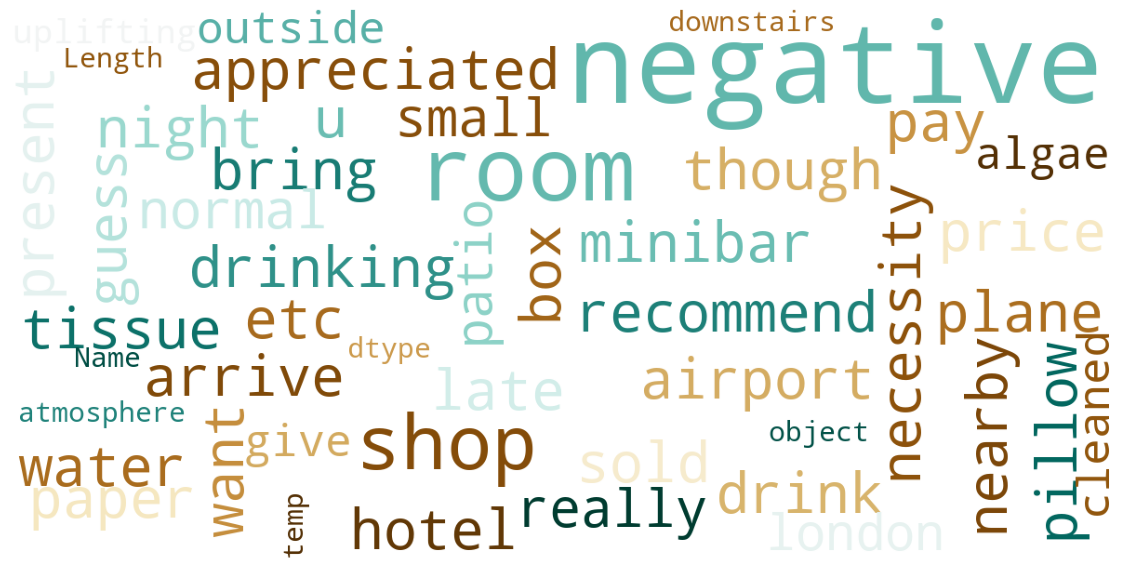

In [37]:
print('\nОБЛАКО СЛОВ НЕГАТИВНЫХ ОТЗЫВОВ:\n')
draw_cloud('negative_review', 'white', 'BrBG');

### Анализ настроений с помощью SentimentIntensityAnalyzer библиотеки VADER:


  SentimentIntensityAnalyzer от VADER выводит оценку на 3 уровнях классификации, а также составную оценку. В результате мы получим словарь нормализованных оценок тональности текста по категориям:
- негативная оценка
- нейтральная оценка
- позитивная

  Из документации VADER по составной оценке: составная оценка вычисляется путем суммирования оценок валентности каждого слова в лексиконе, корректируется в соответствии с правилами, а затем нормализуется так, чтобы быть в диапазоне от -1 (крайнее отрицательное значение) до +1 (крайнее положительное значение).

И все бы хорошо, но одни и те же слова в положительном и отрицательном контекстах будут иметь противоположную тональность.

### “Все” или “Ничего”?

Вспомним, что положительный и отрицательные части отзыва - это ответы на два вопроса сайта о том что понравилось / не понравилось в отеле. А структура английского языка такова (как выяснилось), что ответ на вопрос “Что вам не понравилось?”: “Ничего” (nothing) - будет означать, что ничего не не понравилось, то есть - все понравилось. Самый положительный контекст. Но тоже самое “Ничего” в ответ на вопрос: “Что вам понравилось?” будет означать ровно обратное.

А вот слово “все” (everything) такой семантики не имеет (вроде бы).

Эти слова изначально для анализатора имеют нейтральную тональность, но в качестве ответа на вопрос, хорошо было бы эту тональность именно таких самых популярных слов изменить. Причем разным образом для разных частей отзывов. 

Надо понимать, что конечно, эти слова могут встречаться те только в коротких ответах, но и в развернутых предложениях, где они такого смысла иметь не будут. Но и не будут иметь большого веса в общей оценке. Мы можем этими ситуациями принебречь. 

Так же слово “small” мы встретим в огромной части отрицательных отзывов - Small room, Small bed, Small pool. И невинно нейтральное small в отрицательных отзывах об отелях принимает негативный контекст.

Для работы с разными частями отзывов я создам два разных анализатора - SentimentIntensityAnalyzer, а лексикон каждого настрою для соответствующей части отзывов. 

  И еще один момент. Вообще, метками ‘No Negative’ / ‘No Positive’ обозначается отсутствие отзыва. Если оставить все как есть, то анализатор отбросив “No”, выдаст тональность противоположного по значению слова. Можно вообще удалить эти значения, заменив на пустую строку, но для нас отсутствие отрицательно отзыва - означает - отсутствие отрицательного опыта пребывания и наоборот, по этому оставим эти фразы для анализа, предварительно переформулировав фразы без “не”. А вот если не написано вообще ничего, то взаимные разнонаправленные тональности обеих меток в сумме дадут нейтральный 0.

In [38]:
# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов:
sia_pos = SentimentIntensityAnalyzer()
sia_neg = SentimentIntensityAnalyzer()

# посмотрим как изменится характеристика слова 'nothing':
example = 'nothing'
print(f'Словарь оценок слова "{example}" до преобразований:')
print(sia_neg.polarity_scores(example), '\n')

# добавим контекст:
neg_words = {'small': -1, 'nothing': 10}
pos_words = {'nothing': -10, 'everything': 10}
sia_neg.lexicon.update(neg_words)
sia_pos.lexicon.update(pos_words)

print(f' - после преобразований (для негативного контекста):')
print(sia_neg.polarity_scores(example))
print(f' - после преобразований (для позитивного контекста):')
print(sia_pos.polarity_scores(example))

# фразы "No Negative" тонально будет нести негативную окраску:
example = 'No Negative'
print(f'\nСловарь оценок фразы "{example}":')
print(sia_neg.polarity_scores(example))
example = 'Positive'
print(f'Словарь оценок фразы "{example}":')
print(sia_neg.polarity_scores(example))

# меняем метки отсутствия частей отзыва:
hotels['negative_review_temp'] = hotels['negative_review'].apply(
    lambda x: x.replace('No Negative', 'Positive'))
hotels['positive_review_temp'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

Словарь оценок слова "nothing" до преобразований:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

 - после преобразований (для негативного контекста):
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - после преобразований (для позитивного контекста):
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}

Словарь оценок фразы "No Negative":
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
Словарь оценок фразы "Positive":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [39]:
%%time
# понеслась?)
hotels['negative_review_sentiments'] = hotels['negative_review_temp'].apply(
    lambda x: sia_neg.polarity_scores(x))
hotels['positive_review_sentiments'] = hotels['positive_review_temp'].apply(
    lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
hotels['n_review_sentiments_neg'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['compound'])
# кстати, не очень долго считает (толи еще будет!)

CPU times: user 4min 32s, sys: 3.03 s, total: 4min 35s
Wall time: 4min 35s


### Анализ настроений с помощью TextBlob:

TextBlob работает немного по другому. В отличие от Vader, он анализирует не слова, а фразы и предложения, выдавая такие параметры как: полярность и субъективность.

Полярность — это число с плавающей запятой от -1 до 1, где -1 — отрицательное утверждение, а 1 — положительное утверждение.
Субъективность — это показатель TextBlob, определяющий, считается ли утверждение в большей степени личным мнением или оно основано на фактах.

Для оценки настроения рецензента будем использовать параметр полярности.

Также при помощи NaiveBayesAnalyzer можно получить классификацию настроений (аналогичную Vader) в негативной и позитивной частях отзыва и, на основе этих данных выведем категорию отзыва, руководствуясь следующей логикой:

***- (восторженный) обе части имеют позитивную тональность: высшая категория***
туристу так все понравилось, что и в ответе на вопрос о недостатках - он выражает положительные эмоции

***- (конструктивный) позитивная часть имеют позитивную тональность, негативная часть - негативную: средняя высокая категория***
объективный поиск достоинств и недостатков отеля

***- (снисходительный) позитивная часть имеет негативную тональность, негативная - позитивную: средняя низкая категория***
пребывание скорее не понравилось, но отзыв о недостатках не жесткий

***- (разочарованный) обе части имеют негативную тональность: низшая категория***
ничего не понравилось

Исходя из шкалы оценивания отеля - выберем 4 оценки в диапазоне от 2.5 до 10 с равным шагом.

P.S. тут я еще не знаю, что этот признак-классификацию скорее всего придется удалить из-за сильно корреляции с другим фактором

In [40]:
# так как этот анализатор работает не со словами, а с фразами, 
# то он справляется с выражениями 'No Negative' / 'No Positive':
text_example = 'No Negative'
example = TextBlob(text_example)
print(f'Полярность фразы "{text_example}": \
{round(example.sentiment_assessments.polarity,2)}')

text_example = 'No Positive'
example = TextBlob(text_example)
print(f'Полярность фразы "{text_example}": \
{round(example.sentiment_assessments.polarity,2)}')

Полярность фразы "No Negative": 0.15
Полярность фразы "No Positive": -0.11


In [41]:
%%time

def get_polarity(text):
    """Получение параметра полярности отзыва"""
    blob = TextBlob(text)
    return blob.sentiment_assessments.polarity

hotels['positive_polarity'] = hotels['positive_review_temp'].apply(get_polarity)
hotels['negative_polarity'] = hotels['negative_review_temp'].apply(get_polarity)

CPU times: user 7min 15s, sys: 478 ms, total: 7min 16s
Wall time: 7min 16s


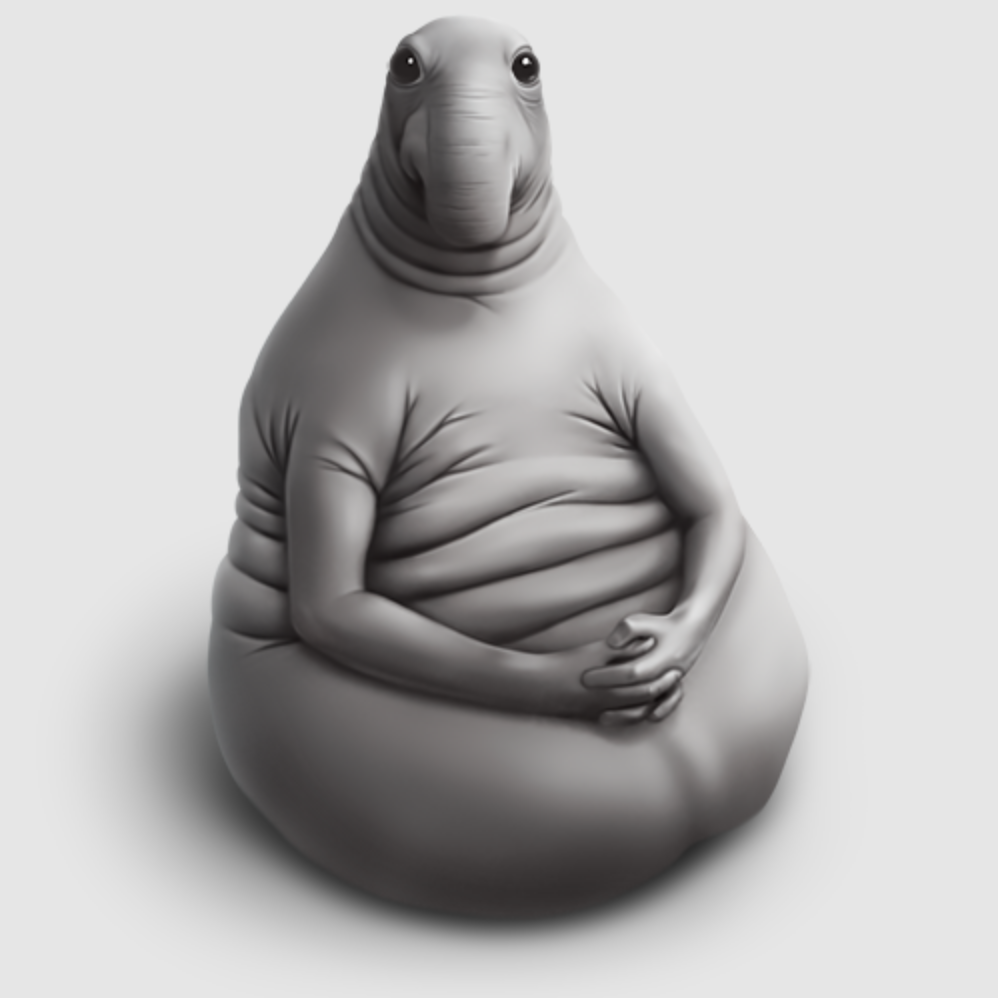

In [42]:
Image(filename='../input/projectdata/wait.png', width=600)

Так же в библиотеке есть способ получить коэффициенты негативной и позитивной окраски (в сумме дают 1) и классифицировать текст в зависимости от того, какой компонент преобладает.

In [43]:
%%time

tb = Blobber(analyzer=NaiveBayesAnalyzer())

text_example = 'everything was great'
print(f'{tb(text_example).sentiment} для фразы "{text_example}"')

# так как позитивный и негативный компонент - взаимнообратные величины, образующие в сумме 1 - 
# можно ограничится только одним:
def get_blobber_sentiment(text):
    """Получение коэффициента позитивной оценки"""
    blobber_sentiment = tb(text).sentiment
    return blobber_sentiment[1]

hotels['positive_review_pos'] = hotels['positive_review_temp'].apply(get_blobber_sentiment)
hotels['negative_review_pos'] = hotels['negative_review_temp'].apply(get_blobber_sentiment)

Sentiment(classification='pos', p_pos=0.6252594845412645, p_neg=0.37474051545873566) для фразы "everything was great"
CPU times: user 7min 23s, sys: 561 ms, total: 7min 24s
Wall time: 7min 25s


In [44]:
# добавим отзыву классификацию в зависимости от доли положительного компонента:
hotels['positive_review_class'] = hotels['positive_review_pos'].apply(
    lambda x: 1 if x >= 0.5 else 0)
hotels['negative_review_class'] = hotels['negative_review_pos'].apply(
    lambda x: 1 if x >= 0.5 else 0)


# добавляем параметр с классификацией отзыва:
def get_class(positive_review_class, negative_review_class):
    """Классификация отзыва, в зависимости от классов обеих частей"""
    if positive_review_class + negative_review_class == 2:
        return 10.0
    if positive_review_class == 1 and negative_review_class == 0:
        return 7.5
    if positive_review_class == 0 and negative_review_class == 1:
        return 5.0
    return 2.5


hotels['review_classification'] = hotels.apply(
    lambda row: get_class(row['positive_review_class'], row['negative_review_class']), 
    axis=1)

### Собственные эксперименты:

Предыдущими методами мы получили несколько классификаций, основанных на анализе настроений, но не учитывающих специфический лексикон рецензентов, пишущих именно об отелях. На самом деле, есть куча конструктивных отзывов, описывающих достоинства обстоятельно, но без сильных эмоций. И хочется понять, что рецензент рассуждает об отеле в ключе самых хвалебных отзывов.

Я попробовала найти простой способ сравнить все отзывы с лучшими и выявить какой-то коэффициент похожести. Но как понять, какие - лучшие? 

Я попробую создать некий набор слов типичных для положительных отзывов, основываясь на положительной части отзывов о лучших отелях (с самым высоким среднем рейтингом). Потом оценим, какой процент слов каждого отзыва пересекается с этим набором.

(Кстати с отрицательными отзывами - этот подход не сработал, так как люди пишут отрицательные отзывы часто более обстоятельно, даже если не сильно снижают оценку.)

In [45]:
%%time

# формируем единый блок текста обеих частей отзыва и избавляемся от меток отсутствия слов:
hotels['negative_review_temp'] = hotels['negative_review'].apply(
    lambda x: x.replace('No Negative', ''))
hotels['positive_review_temp'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', ''))
hotels['review'] = hotels['positive_review_temp'] + ' ' + hotels['negative_review_temp']


# функция преобразования строки в набор слов:
def get_words_set(text):
    """Формирование наборов уникальных слов текста"""
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word for word in text if len(word) > 2]
    text = [word for word in text if word not in stop]
    text = " ".join(text)
    words_data = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    words_set = set()
    for word in words_data:
        words_set.add(word)
    return words_set


# формируем наборы уникальных слов каждого отзыва:
hotels['review_word_set'] = hotels['review'].apply(get_words_set)

# зато быстро!

CPU times: user 1min 51s, sys: 1.07 s, total: 1min 52s
Wall time: 1min 52s


In [46]:
best_words_set = set()

# подберем образцы текста отзывов о лучших отелях:
hotels_top = pd.DataFrame(hotels[hotels['average_score'] >= 9.6])
hotels_top['positive_review_word_set'] = hotels_top['positive_review'].apply(get_words_set)
hotels_top_list = hotels_top['positive_review_word_set'].tolist()

for review_set in hotels_top_list:
    best_words_set.update(review_set)

best_hotels_count = len(hotels[hotels['average_score'] >= 9.6]['hotel_name'].value_counts())

print(f'Количество уникальных слов, отобранное по результатам {len(hotels_top_list)} отзывов '
      f'{best_hotels_count} лучших отелей: {len(best_words_set)}.')

Количество уникальных слов, отобранное по результатам 943 отзывов 7 лучших отелей: 2044.


In [47]:
def get_diff_with_top(review_words_set):
    """Определение доли слов отзыва, встречающихся также в отзывах о топ-отелях"""
    set_len = len(review_words_set)
    if set_len == 0:
        return 0
    top_words_count = 0
    for word in review_words_set:
        if word in best_words_set :
            top_words_count += 1

    return round(top_words_count / set_len, 2)


# формируем новый признак:
hotels['review_difference_with_top'] = hotels['review_word_set'].apply(get_diff_with_top)

### Бонус! Короткий код с Afinn:

На самом деле, решений задач сентимент-анализа - огромное множество, куча библиотек и разных анализаторов. Те, которые использовала я - наверно самые популярные и довольно понятные новичку.

Однако, блуждая по бескрайним просторам интернета, я наткнулась еще на один лаконичный и простой способ получить коэффициент настроения текста. Afinn — это подход к анализу настроений на основе списка слов. Он не нормализует оценки и мы получаем коэффициент, соотносимый с масштабом количества слов отзыва. То есть, своего рода взвешенную по количеству слов оценку:

In [48]:
%%time
# получаем счет:
afinn = Afinn()
hotels['afinn_score'] = hotels['review'].apply(lambda x: afinn.score(x))

CPU times: user 10min 5s, sys: 130 ms, total: 10min 5s
Wall time: 10min 5s


#### <span style="color:green">Визуализируем соотношение оценок туристами и коэффициентов afinn:</span>

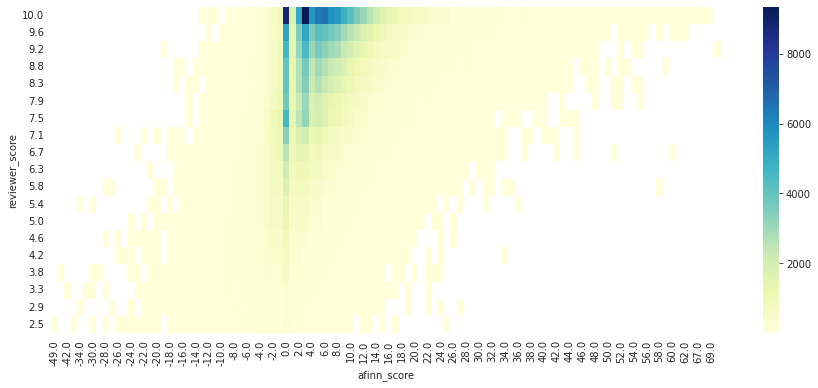

In [49]:
# красивая тепловая карта под конец раздела:
hotels_filtered = hotels[mask & (hotels['reviewer_score'].isin(
    scores_list_1.index.to_list()))]
pivot = hotels_filtered.pivot_table(
    values='review', 
    index='reviewer_score', 
    columns='afinn_score', 
    aggfunc='count')

# строим диаграмму:
fig8, ax8 = plt.subplots(1, 1, figsize = (15, 6))
afinn_heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
ax8.invert_yaxis();

In [50]:
# ограничим размеры диапазона значений по методу Тьюки:
def get_outliers_bonds(data, feature):
    """Определяем границы диапазонов для ограничения значений"""
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower = quartile_1 - (iqr * 1.5)
    upper = quartile_3 + (iqr * 1.5)
    return lower, upper


lower_bound, upper_bound = get_outliers_bonds(hotels, 'afinn_score')

hotels['afinn_score'] = hotels['afinn_score'].apply(
    lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# 2. Анализ и отбор признаков (FEATURE SELECTION):

In [51]:
# создаем дубликат базы для дальнейших манипуляций со столбцами (для обратимости экспериментов):
hotels_copy = hotels.copy()

In [52]:
print(f'Текущее получившееся количество признаков: {len(hotels_copy.columns)}')
print('(включая целевой столбец и метку тест/трейн)')

# удалим нечисловые данные:
object_columns = [s for s in hotels.columns
                  if ((hotels[s].dtypes == 'object') | \
                      (hotels[s].dtype.name == 'category') | \
                      (hotels[s].dtypes == 'datetime64[ns]'))]

print(f'Удалим {len(object_columns)} столбцов с нечисловыми данными')
hotels_copy = hotels_copy.drop(object_columns, axis = 1)

Текущее получившееся количество признаков: 81
(включая целевой столбец и метку тест/трейн)
Удалим 17 столбцов с нечисловыми данными


### Разделим числовые признаки на группы:

In [53]:
# непрерывные и категориальные признаки:
num_cols = [
    # признаки связанные с количеством слов:
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'review_total_word_counts_diff_norm', 'review_positive_word_proportion',

     # признаки, связанные с анализом эмоциональной окраски отзывов:
    'n_review_sentiments_neg', 'n_review_sentiments_neu',
    'n_review_sentiments_pos', 'n_review_sentiments_compound',
    'p_review_sentiments_neg', 'p_review_sentiments_neu',
    'p_review_sentiments_pos', 'p_review_sentiments_compound',
    'negative_polarity', 'positive_polarity', 
    'negative_review_pos', 'positive_review_pos', 
    'review_difference_with_top', 'afinn_score',

    # остальные количественные:
    'total_number_of_reviews_reviewer_has_given', 'tag_count_nights'
]

cat_cols = [
    # характеристики отеля
    'average_score', 'additional_number_of_scoring', 'total_number_of_reviews',
    'hotel_code', 'hotel_country_code', 'district_code', 
    'district_rating', 'hotel_distance_to_center',

    # характеристики поездки (номер):
    'tag_leisure_trip', 'tag_view_room', 'room_type_without Window', 
    'room_type_Suite', 'room_type_Standard', 'room_type_Double',
    'room_type_Superior', 'room_type_Club', 'room_type_Comfort', 
    'room_type_Deluxe', 'room_type_Premier', 'room_type_Classic', 
    'room_type_King', 'room_type_Single', 'room_type_Guestroom', 'room_type_Other',

    # характеристики рецензента:
    'reviewer_en', 'reviewer_n_est', 'reviewer_resident', 'reviewer_nationality_cat', 
    'tag_from_mobile', 'tag_with_pet',
    'tag_reviewer_type_1.0', 'tag_reviewer_type_2.0', 'tag_reviewer_type_3.0',
    'tag_reviewer_type_4.0', 'tag_reviewer_type_5.0', 'tag_reviewer_type_6.0',

    # время поездки:
    'review_week', 'review_month',

    # характеристики отзыва:
    'review_classification', 'positive_words_more', 
    'negative_review_class', 'positive_review_class',
]

## 2.1 АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ


Поскольку признаков очень много оценим коллинеарность по смысловым группам:

### АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ НЕПРЕРЫВНЫХ ПРИЗНАКОВ

In [54]:
def show_corr_heatmap(columns_list, title, method):
    """Построения корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = hotels[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()

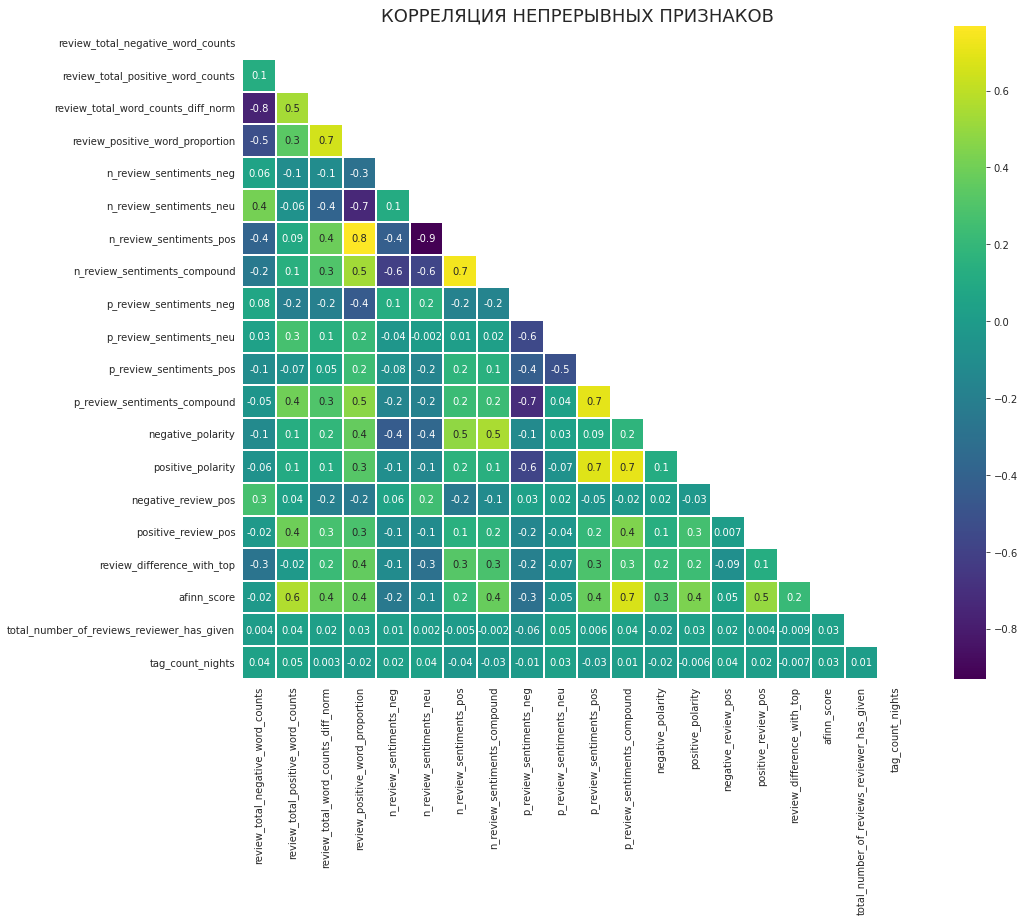

In [55]:
#строим диаграмму для непрерывных признаков:
show_corr_heatmap(num_cols, 'КОРРЕЛЯЦИЯ НЕПРЕРЫВНЫХ ПРИЗНАКОВ', method='pearson');

Отбираем на удаление два признака из пар имеющих модуль корреляции больше 0.8.

In [56]:
# внесем столбцы в список на удаление:
drop_columns = ['n_review_sentiments_neu']

### АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Разделим категориальные признаки на 2 смысловые группы:

In [57]:
# в первый блок отнесем характеристики отеля и номера:
cat_cols_p1 = cat_cols[:24]

# во второй блок - характеристики рецензента, времени поездки и отзыва:
cat_cols_p2 = cat_cols[24:]

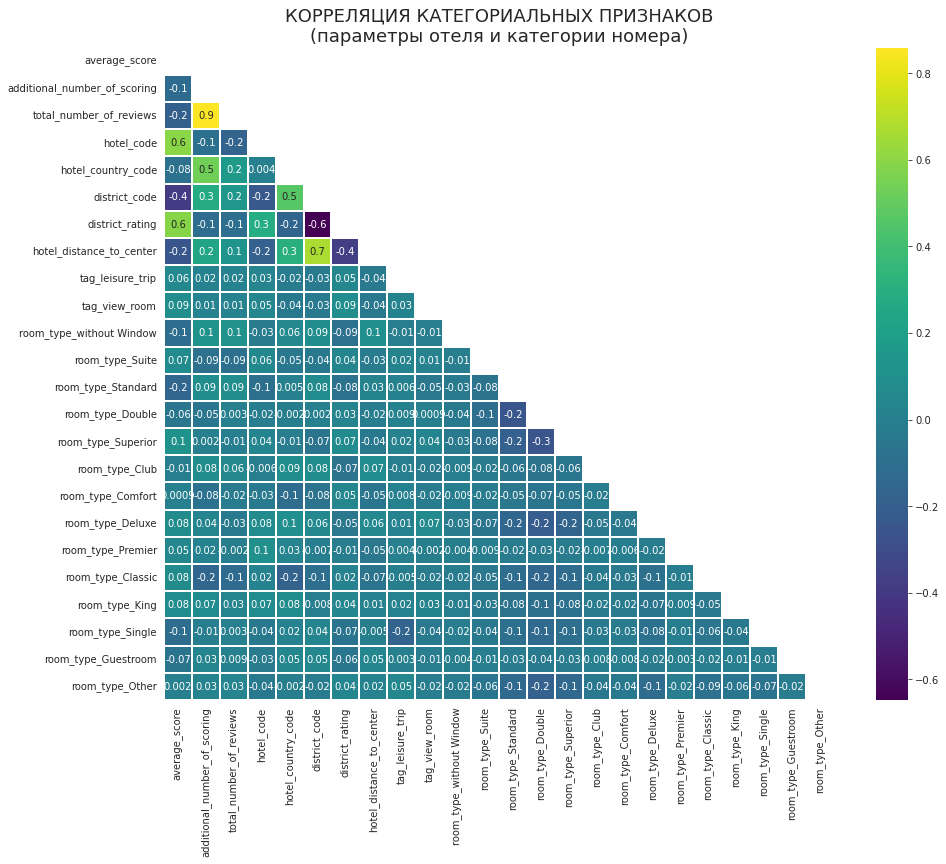

In [58]:
# строим диаграмму для первой части категориальных признаков:
show_corr_heatmap(
    cat_cols_p1, 
    'КОРРЕЛЯЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ\n(параметры отеля и категории номера)', 
    method='spearman'
);

In [59]:
# внесем столбцы в список на удаление:
drop_columns += ['additional_number_of_scoring']

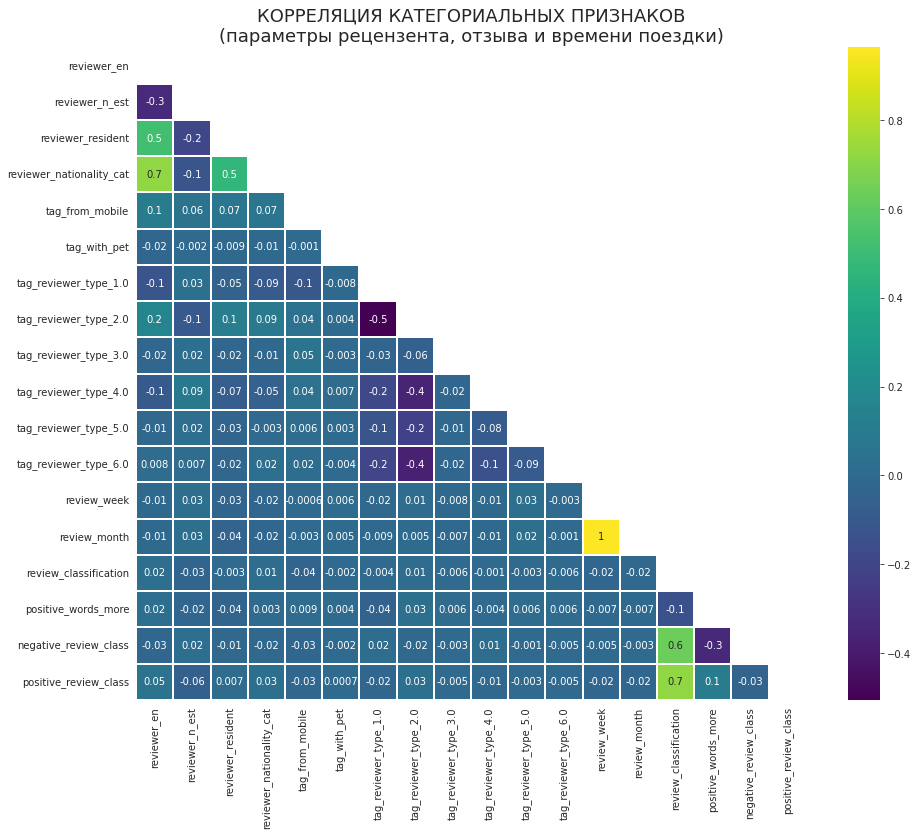

In [60]:
# строим диаграмму для первой части категориальных признаков:
show_corr_heatmap(
    cat_cols_p2, 
    'КОРРЕЛЯЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ\n(параметры рецензента, отзыва и времени поездки)', 
    method='spearman'
);

А из этого списка можно удалить признак недели или месяца (удалим месяц) и классификацию отзыва (он сильно коррелирует с признаками из которых выведен).

In [61]:
# внесем столбцы в список на удаление:
drop_columns += ['review_month', 'review_classification']

In [62]:
# удалим выбранные столбцы:
hotels_copy.drop(drop_columns, axis = 1, inplace=True)

print(f'Текущее получившееся количество признаков: {len(hotels_copy.columns)}')
print('(включая столбец "Sample" и целевой столбец)')

Текущее получившееся количество признаков: 60
(включая столбец "Sample" и целевой столбец)


## 2.2 ОЦЕНКА ЗНАЧИМОСТИ ПРИЗНАКОВ

Проведем оценку значимости признаков. Я бы отнесла наш целевой признак к категории - количественный дискретный. Воспользуемся для оценки дисперсионным анализом ANOVA. Теперь делить признаки на группы не корректно, нам нужно получить абсолютно худшие во всей совокупности:

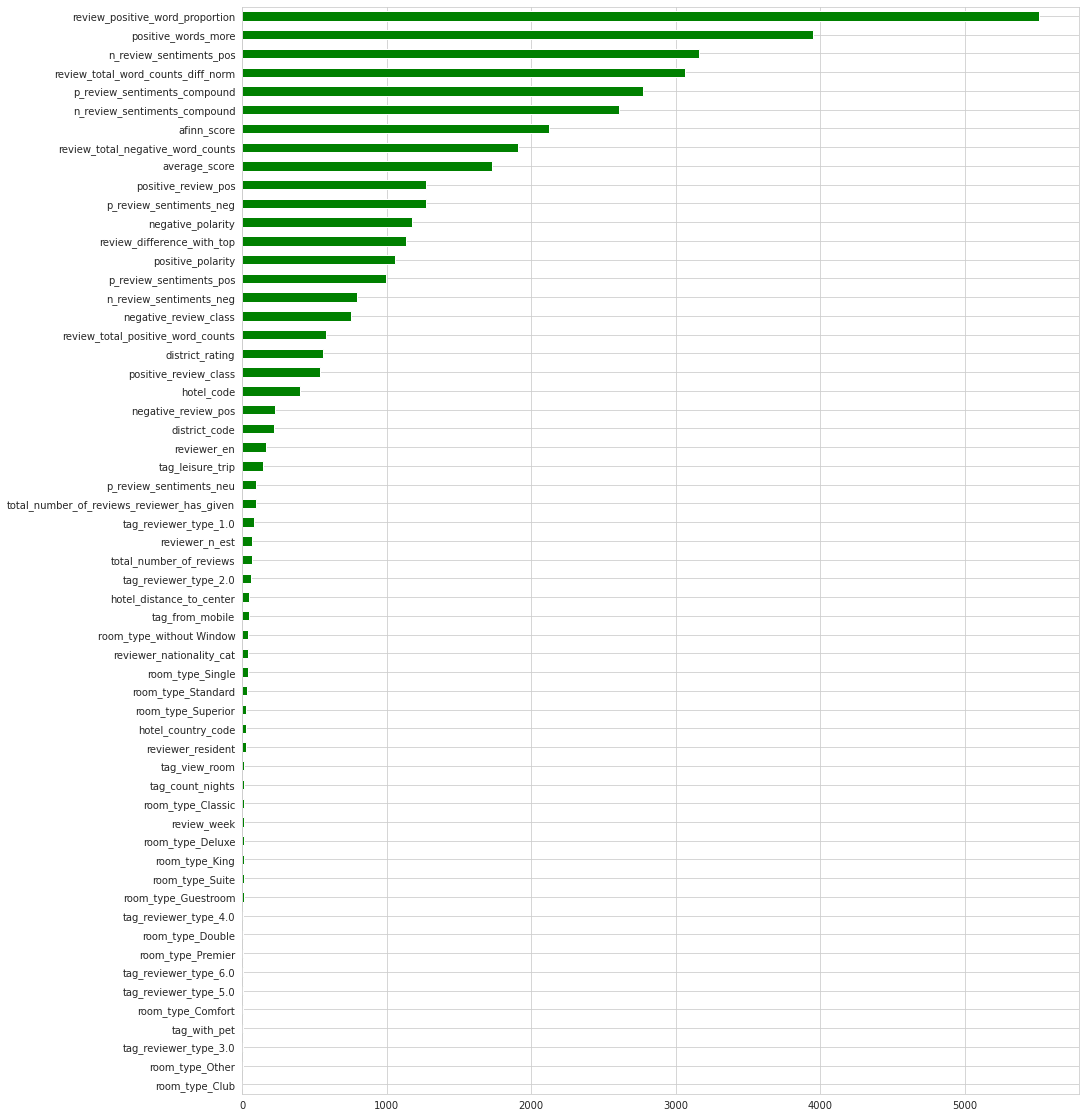

In [63]:
y = hotels_copy.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = hotels_copy.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

Удалим признаки, не демонстрирующие никакой корреляции с целевым. Это признаки некоторых типов номеров и типов путешественника, а также признак путешественников с животными.

Хотя у меня была гипотеза, что может быть их оценки в целом выше, так как не многие отели пускают постояльцев с домашними питомцами, и возможно, благодарные хозяева оставляют позитивные отзывы. Но нет...)

In [64]:
drop_columns = ['room_type_Other', 'room_type_Club', 'room_type_Comfort', 
                'room_type_Double', 'room_type_Premier', 'tag_with_pet',
                'tag_reviewer_type_3.0', 'tag_reviewer_type_4.0', 
                'tag_reviewer_type_5.0', 'tag_reviewer_type_6.0']

In [65]:
# удалим незначимые числовые данные:
print(f'Удалим еще {len(drop_columns)} столбцов с числовыми данными')
hotels_copy.drop(drop_columns, axis = 1, inplace=True)

print(f'Итоговое получившееся количество признаков: {len(hotels_copy.columns)}')
print('(включая столбец "Sample" и целевой столбец)')

Удалим еще 10 столбцов с числовыми данными
Итоговое получившееся количество признаков: 50
(включая столбец "Sample" и целевой столбец)


# 3. Обучение модели и получение предсказания (Model Building):

### Разбиваем датафрейм на части, необходимые для обучения и тестирования модели:

In [66]:
# теперь выделим тестовую часть
train_data = hotels_copy.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_copy.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [67]:
# воспользуемся специальной функцие train_test_split для разделения тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [68]:
# проверяем размеры:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 49), (386803, 49), (386803, 48), (309442, 48), (77361, 48))

### Создаем модель и получаем предсказание:

In [69]:
# НАСТРОЙКИ НЕ ТРОГАЕМ
model = RandomForestRegressor(
    n_estimators=100, 
    verbose=1, 
    n_jobs=-1, 
    random_state=RANDOM_SEED)

In [70]:
%%time

# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


CPU times: user 18min 1s, sys: 3.06 s, total: 18min 4s
Wall time: 4min 37s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [71]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), 
# метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную 
# процентную ошибку предсказанных значений от фактических:

def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 11.92


### Оценим вклад важнейших признаков в построение модели:

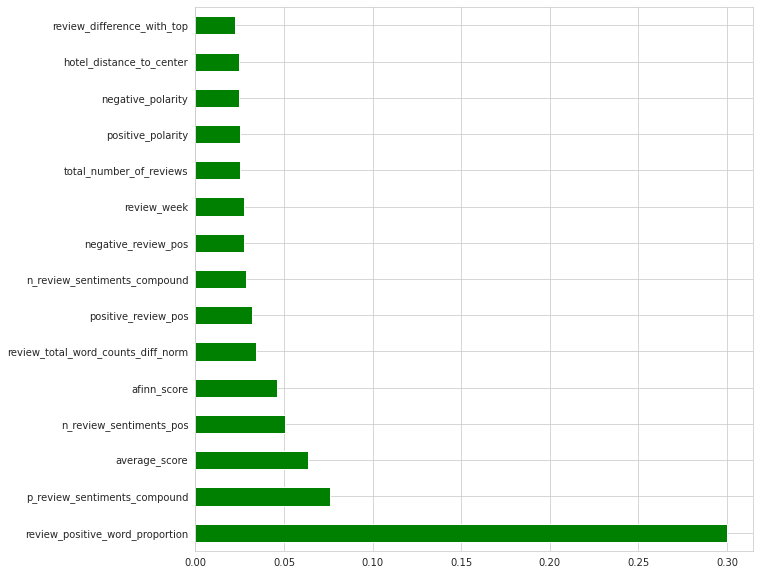

In [72]:
# в RandomForestRegressor есть возможность вывести самые важные признаки
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color='green');

### Получаем предсказание целевой переменной:

In [73]:
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission

#  сохраняем результат:
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.9s finished


,reviewer_score,id
0,8.748,488440
1,6.843,274649
2,8.056,374688
3,9.896,404352
4,9.683,451596
5,8.867,302161
6,7.848,317079
7,7.898,13963
8,8.594,159785
9,7.875,195089


#### Среди 15 главных для построения модели признаков с итоговым MAPE 11.92 - только два исходных - рейтинг отеля и общее количество отзывов об отеле (несправедливо недооцененный мной признак). Остальные - это признаки, сконструированные в процессе исследования данных. Учитывая, что критерий MAPE на необработанных данных - 14.14%, только при помощи инструментов EDA мне удалось улучшить его примерно на 15,5 процентов. В ряду важнейших признаков есть и дистанция до центра и соотношение количества слов в разных частях отзыва. Но конечно, главную роль сыграли признаки, отвечающие за определение эмоциональной окраски текста.

P.S. Это ноутбук предпоследнего, не самого лучшего моего решения. В последнем варианте, по прежнему не меняя вида и настроек модели, только за счет EDA (работы с признаками) мне удалось улучшить итоговую метрику MAPE до значения 11.55. Учитывая, что это текущее первое место соревнования, считаю, что обнародовать его будет немного не спортивно :D

Если вы в данный момент выполняете свой проект - желаю вам вдохновения и удачи. На все вопросы отвечу с удовольствием!